# Seeing the US through the lens of beer reviews


WRITE SOMETHING

In [112]:
import pandas as pd
import geopandas as gpd

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import wordcloud

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
    get_us_reviews
)

from pretty_plot import (
    plot_climate_one_stat,
    plot_climate_multiple_stats,
    spider_plot,
    plot_on_beers
)

In [113]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

# 1) Loading data 

- All the pre-processing is done using the functions defined in `data_loader.py`.
- The preprocessing functions are described and documented in `data_loader.py`.
- We use the reviews/ ratings from both BeerAdvocate and RateBeer, and use the matched beers and breweries dataset to make sure that the names of the same beers are identical across the two datasets.
- Those two reviews/ ratings datasets are then merged and joined to the breweries, beers and users datasets to obtain a single complete dataframe of beer reviews.
- After all the processing and merging is done, the final dataframe is saved as `data/us_users_ratings.csv` to be used in the analysis.

Run only if the dataframe is not already created, otherwise run only the next cells.

In [114]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)
climate_classifications = pd.read_csv("data/climate_classified.csv")
climate_classifications.set_index("climate", inplace=True)
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)
general_style_df = pd.read_csv("data/general_styles.csv")
us_users_ratings = get_us_reviews(
    reviews_df=reviews_df,
    climate_classifications=climate_classifications,
    states_climate=states_climate,
    general_style=general_style_df,
)

# save csv
us_users_ratings.to_csv("data/us_users_ratings.csv", compression="gzip", index=False)

In [115]:
# If the data is already saved, load it
us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")

C:\Users\Admin\AppData\Local\Temp\ipykernel_8432\2879864755.py:2: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")


The following cell displays the dataframe to ensure that the data is loaded correctly.

In [116]:
us_users_ratings.head()

,beer_id,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,...,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style
0,19827,1417431600,Hellpop65,hellpop65.48993,NaN,NaN,NaN,NaN,NaN,3.25,...,5,5,Kansas,2326.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
1,19827,1401357600,Latarnik,latarnik.52897,NaN,NaN,NaN,NaN,NaN,3.50,...,5,5,New Jersey,3098.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
2,19827,1393412400,RochefortChris,rochefortchris.697017,NaN,NaN,NaN,NaN,NaN,3.50,...,5,5,North Carolina,1866.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
3,19827,1392030000,OKCNittany,okcnittany.144868,NaN,NaN,NaN,NaN,NaN,3.75,...,5,5,Oklahoma,1131.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
4,19827,1390647600,jaydoc,jaydoc.265507,NaN,NaN,NaN,NaN,NaN,3.25,...,5,5,Kansas,9987.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale


# 2) Analysis of the scores

In this first part, we will look at the different ratings (`overall`, `aroma`, `appearance`, `palate`, `taste`) of the beers. In order to understand better how they vary in the United States, we will analyze them by different climates. We use the [Köppen climate classification](https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification) to classify the different climates. This scale will also be decomposed into its three level: scheme, precipitation and temperature. This will help get better interpretabilities of the results.

The already pre-processed data is loaded in the following cell and then reduce it to the variables of interest.

In [117]:
us_users_ratings_scores = us_users_ratings.copy()

# For the analysis, drop NaN from the scores columns
us_users_ratings_scores = us_users_ratings_scores.dropna(
    subset=["aroma", "appearance", "palate", "taste", "overall", "rating"]
)

First look at the ratings for a sanity check. They all have a distribution between 1 and 5.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categori

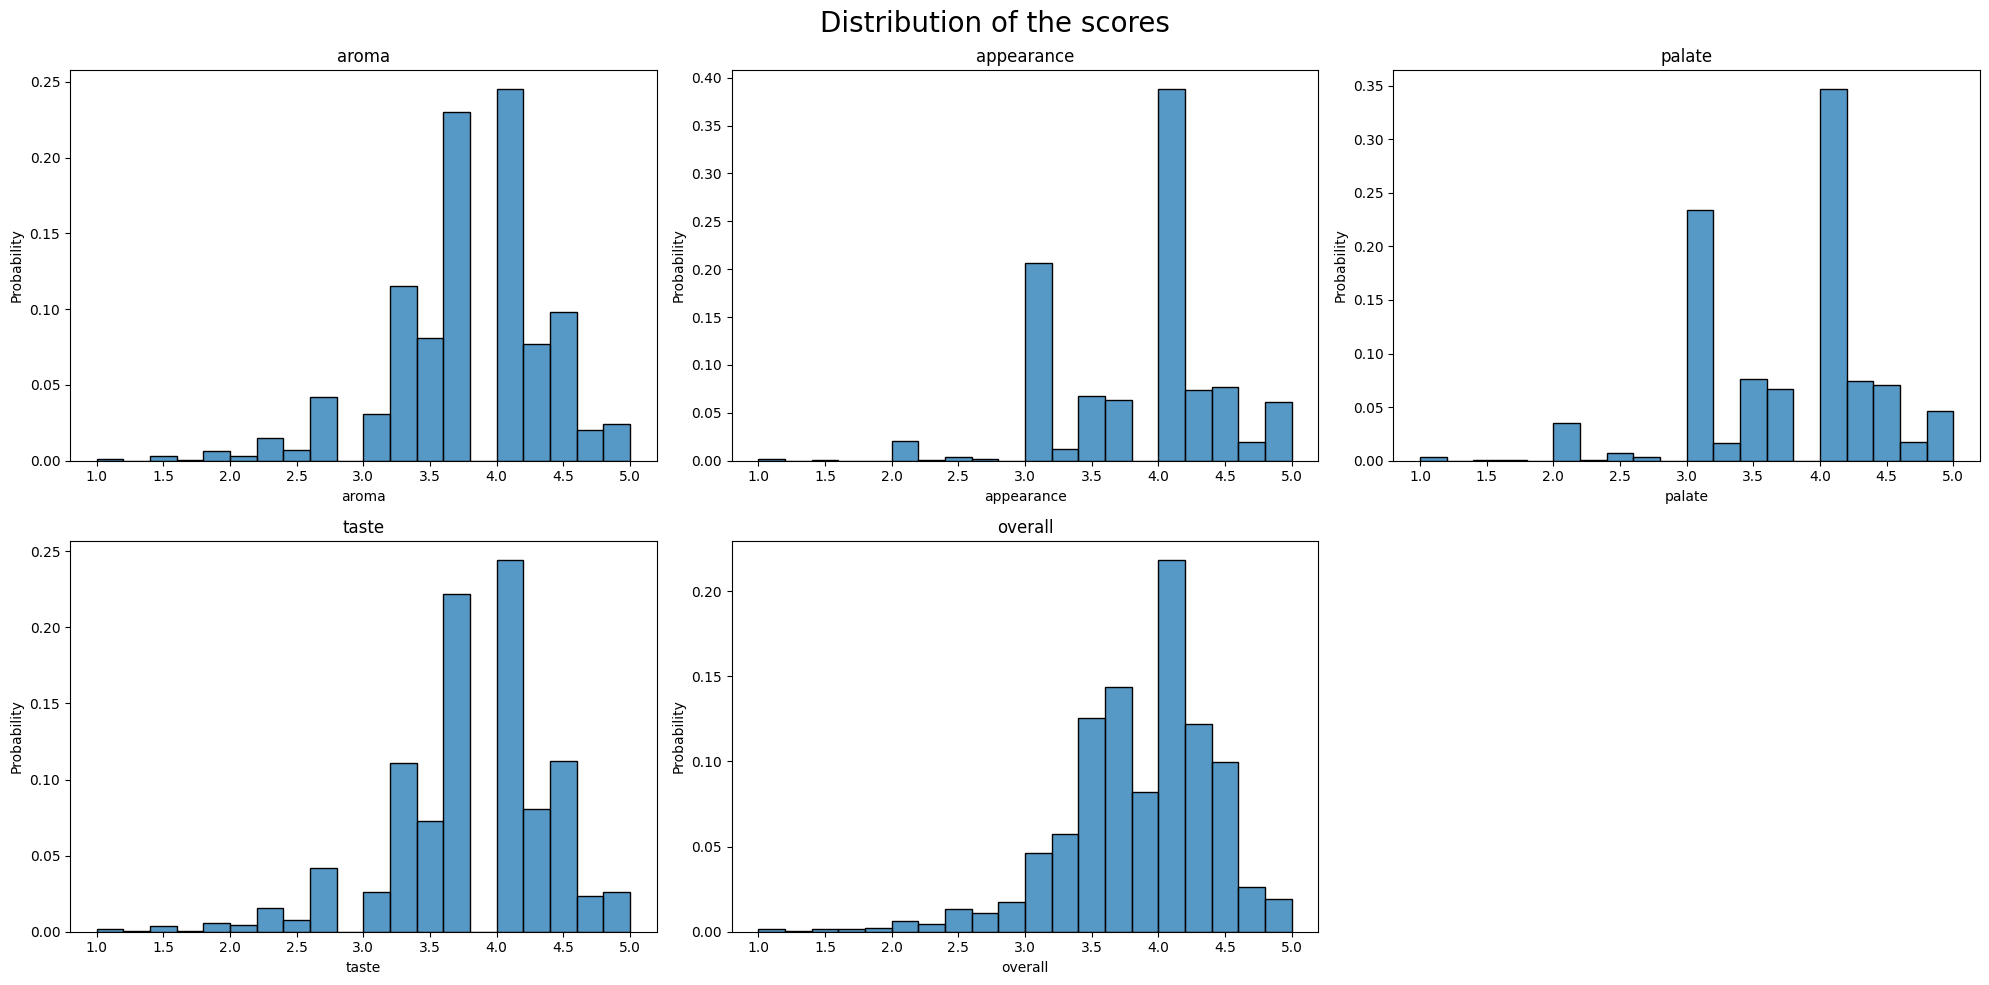

In [118]:
# Compute for each main score the max and min score
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

# Plot the distribution of the scores
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    ax = axs[i // 3][i % 3]
    sns.histplot(us_users_ratings_scores[score], ax=ax, stat="probability", bins=20)
    ax.set_title(score)

axs[1][2].set_visible(False)

fig.suptitle("Distribution of the scores", fontsize=20)
plt.tight_layout()
plt.show()

We can also take a look at the maps of the different climates in the US. We will also plot the 3 sub-categories of climate.

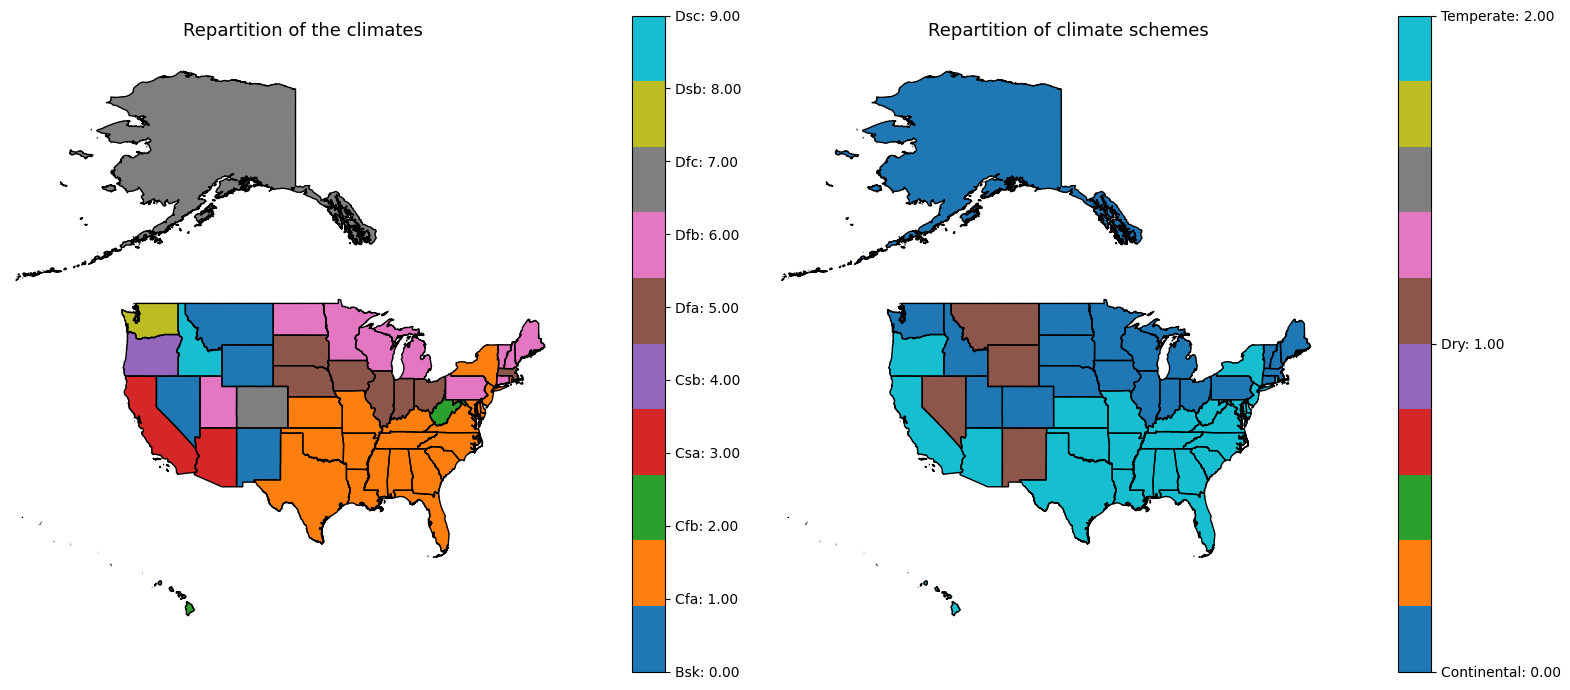

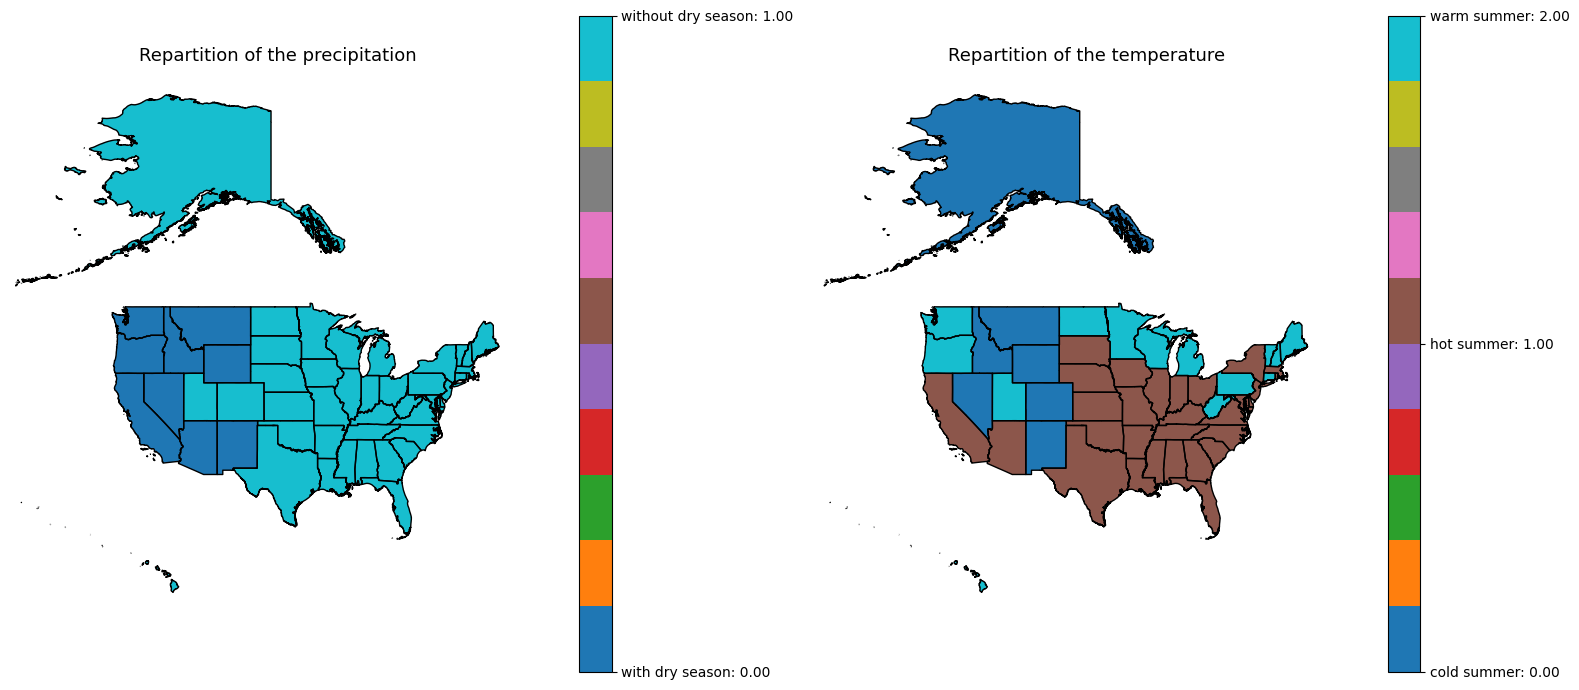

In [119]:
climate_df = pd.read_csv("data/climate_classified.csv")

climate_df["climate_code"] = climate_df["climate"].astype("category").cat.codes
climate_df["scheme_code"] = climate_df["scheme"].astype("category").cat.codes
climate_df["precipitation_code"] = (
    climate_df["seasonal_precipitation"].astype("category").cat.codes
)
climate_df["temperature_code"] = climate_df["heat_level"].astype("category").cat.codes

plot_climate_multiple_stats(
    climate_df,
    ["climate_code", "scheme_code"],
    ["Repartition of the climates", "Repartition of climate schemes"],
    ["climate", "scheme"],
    cmap_name="tab10",
    separate_colorbars=True,
)
plot_climate_multiple_stats(
    climate_df,
    ["precipitation_code", "temperature_code"],
    ["Repartition of the precipitation", "Repartition of the temperature"],
    ["seasonal_precipitation", "heat_level"],
    cmap_name="tab10",
    separate_colorbars=True,
)

We can also look at the distribution of the ratings for each climate:

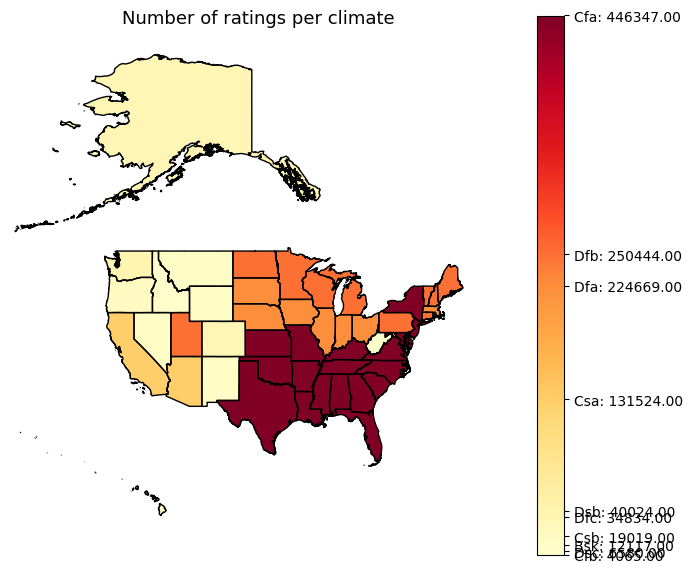

In [120]:
plot_num_ratings = us_users_ratings.groupby("climate").count()["rating"]
plot_num_ratings_df = pd.DataFrame(plot_num_ratings)
plot_num_ratings_df.reset_index(inplace=True)

plot_climate_one_stat(
    plot_num_ratings_df, "rating", "Number of ratings per climate", "climate"
)

## 2.1) Using climate for grouping

We are going to groupby the climate of the state and then plot the mean of the ratings. We will also plot the mean of the ratings for the whole United States for comparison. In each step a one-way ANOVA test will be performed to see if the difference is significant in between the different climates.

First, we compute the mean of the ratings. There are two ways to do so:
- Compute the mean of each reviews directly: the micro average
- Compute the mean of the mean for each climate: the macro average

Both are computed and will be used as a way to compare the results with a baseline.

In [121]:
micro_average_ratings = (
    us_users_ratings_scores[scores_to_compare]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
micro_average_ratings.columns = ["score", "mean"]


display(micro_average_ratings)


# Let's compute statistics for each climate


climate_average_ratings = (
    us_users_ratings_scores.groupby("climate")[scores_to_compare]
    .mean()
    .sort_values(by="overall", ascending=False)
    .reset_index()
)
climate_average_ratings.set_index("climate", inplace=True)


macro_average_ratings = (
    climate_average_ratings.mean().sort_values(ascending=False).reset_index()
)
macro_average_ratings.columns = ["score", "mean"]


display(macro_average_ratings)

,score,mean
0,overall,3.858160
1,appearance,3.809361
2,taste,3.791102
3,aroma,3.768450
4,palate,3.711874


,score,mean
0,overall,3.834160
1,appearance,3.788386
2,taste,3.751408
3,aroma,3.730139
4,palate,3.676703


Now, for each climate we compute the different scores' average and plot them to compare in between them and with the global average.

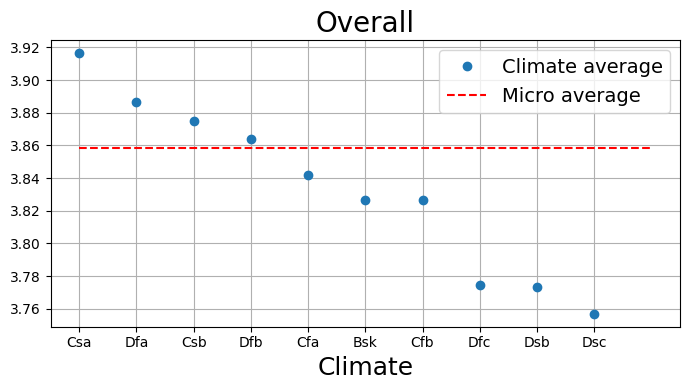

In [212]:
# Plot the "overall" mean as a function of the climate
fig, axs = plt.subplots(figsize=(7, 4))

# Select the "overall" score
overall_scores = climate_average_ratings["overall"]

axs.plot(overall_scores, "o", label="Climate average")
micro_average_value = micro_average_ratings[
    micro_average_ratings["score"] == "overall"
]["mean"].values[0]
axs.plot(
    [0, len(overall_scores)],
    [micro_average_value, micro_average_value],
    "r--",
    label="Micro average",
)
axs.set_title("Overall", fontsize=20)  # Increased title font size
axs.set_xticks(range(len(overall_scores)))
axs.set_xlabel("Climate", fontsize=18)  # Set x-axis label and increase font size
axs.legend(fontsize=14)  # Increased legend font size
axs.grid()
plt.tight_layout()
plt.savefig("figures/overall_climate.png", dpi=600)
plt.show()

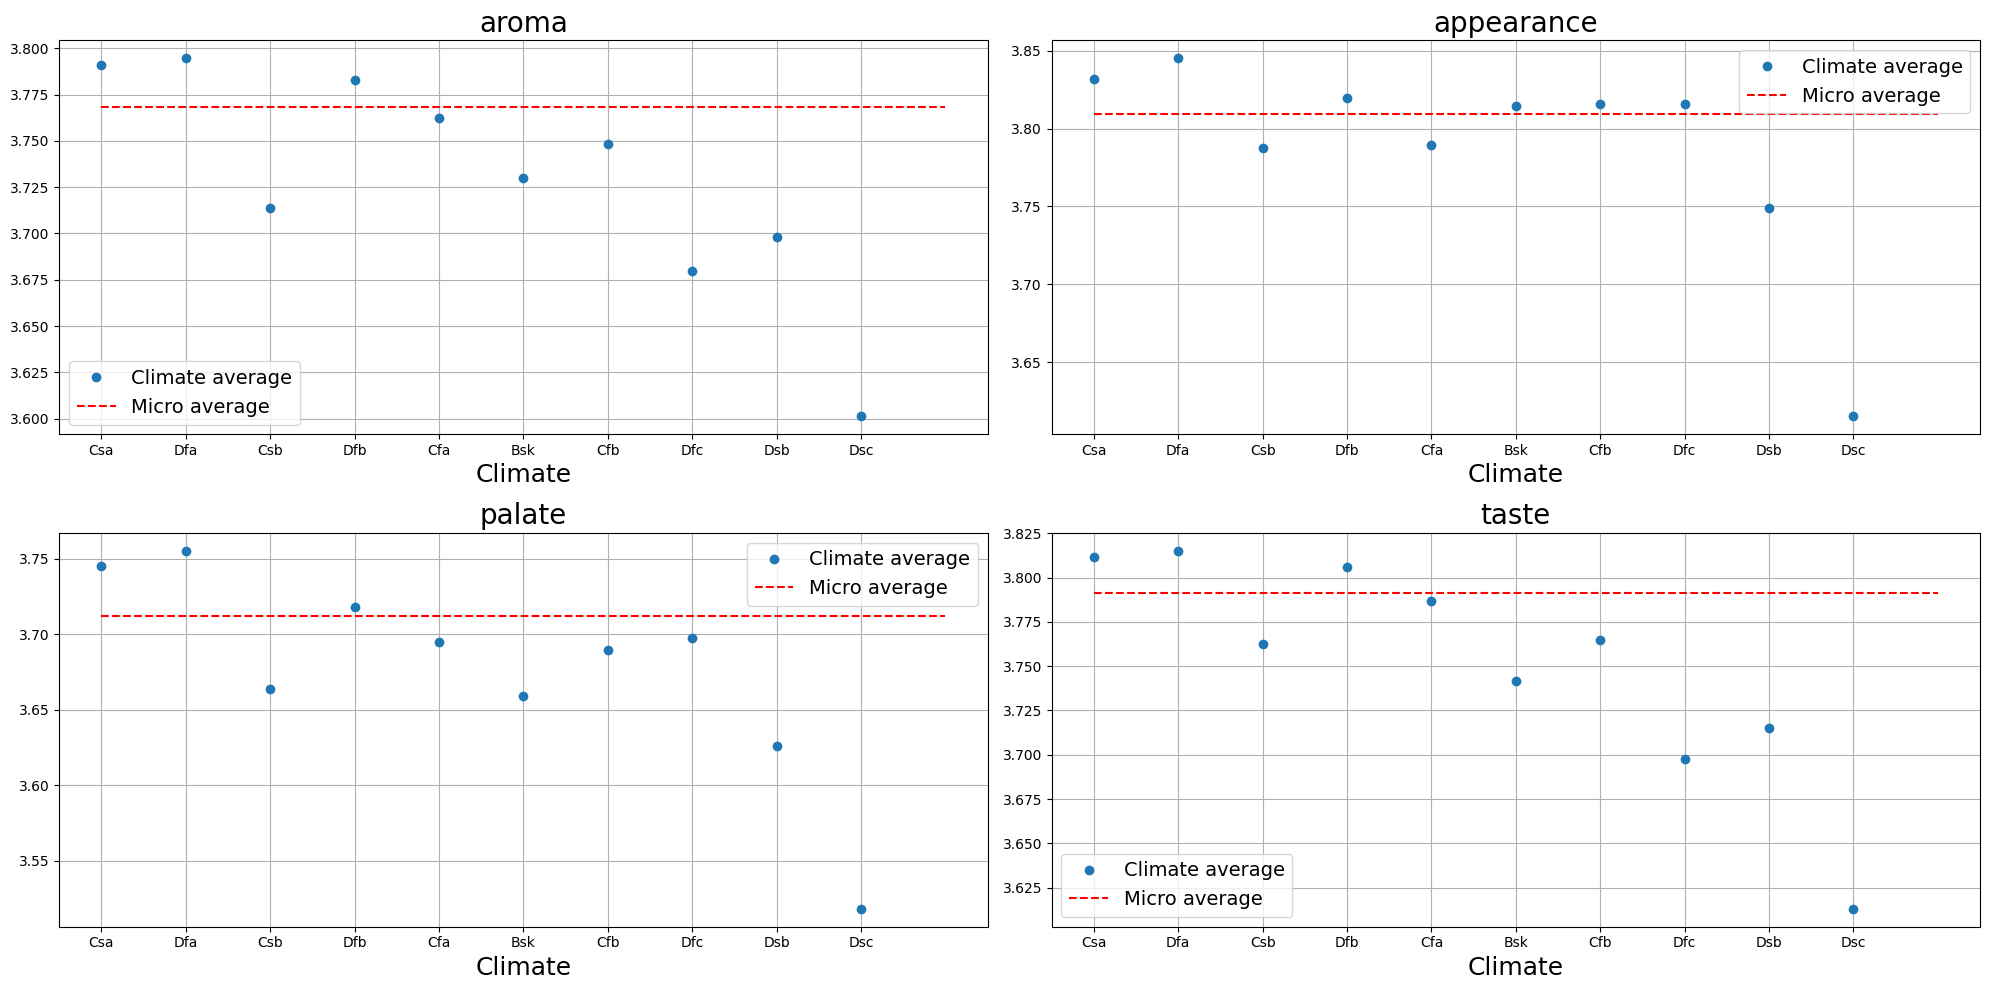

In [213]:
# Plot the different mean as a function of the climate
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i in range(2):
    axs[i, 0].plot(climate_average_ratings.iloc[:, 2 * i], "o", label="Climate average")
    micro_average_value = micro_average_ratings[
        micro_average_ratings["score"] == scores_to_compare[2 * i]
    ]["mean"].values[0]
    axs[i, 0].plot(
        [0, len(climate_average_ratings)],
        [micro_average_value, micro_average_value],
        "r--",
        label="Micro average",
    )
    axs[i, 0].set_title(
        scores_to_compare[2 * i], fontsize=20
    )  # Increased title font size
    axs[i, 0].set_xticks(range(len(climate_average_ratings)))
    axs[i, 0].set_xlabel(
        "Climate", fontsize=18
    )  # Set x-axis label and increase font size
    axs[i, 0].legend(fontsize=14)  # Increased legend font size
    axs[i, 0].grid()

    axs[i, 1].plot(
        climate_average_ratings.iloc[:, 2 * i + 1], "o", label="Climate average"
    )
    micro_average_value = micro_average_ratings[
        micro_average_ratings["score"] == scores_to_compare[2 * i + 1]
    ]["mean"].values[0]
    axs[i, 1].plot(
        [0, len(climate_average_ratings)],
        [micro_average_value, micro_average_value],
        "r--",
        label="Micro average",
    )
    axs[i, 1].set_title(
        scores_to_compare[2 * i + 1], fontsize=20
    )  # Increased title font size
    axs[i, 1].set_xticks(range(len(climate_average_ratings)))
    axs[i, 1].set_xlabel(
        "Climate", fontsize=18
    )  # Set x-axis label and increase font size
    axs[i, 1].legend(fontsize=14)  # Increased legend font size
    axs[i, 1].grid()

plt.tight_layout()
plt.savefig("figures/climate_average_ratings.png", dpi=600)
plt.show()

Looking at the prevous plots it seems that the climate has an impact on the ratings, with a maximum difference of around 0.2. However the difference is still not very big and we need to perform a statistical test to see if the difference is significant. Furthermore, looking at these plots it is hard to interpret anything, we need to decompose the climate into its three components: scheme, precipitation and temperature.

Let's go in more in-depth analysis of the climate distribution.

First, we can notice that the number of reviews highly variates in between the different climates. This might be a problem for the analysis as the number of reviews is not the same in between the different climates.

In [123]:
# First we can print the number of reviews per climate
print("Number of reviews per climate:")
display(us_users_ratings_scores["climate"].value_counts())

Number of reviews per climate:


climate
Cfa    329893
Dfb    184476
Dfa    160204
Csa     94906
Dsb     31820
Dfc     27793
Csb     15040
Bsk      9551
Dsc      5990
Cfb      3070
Name: count, dtype: int64

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categori

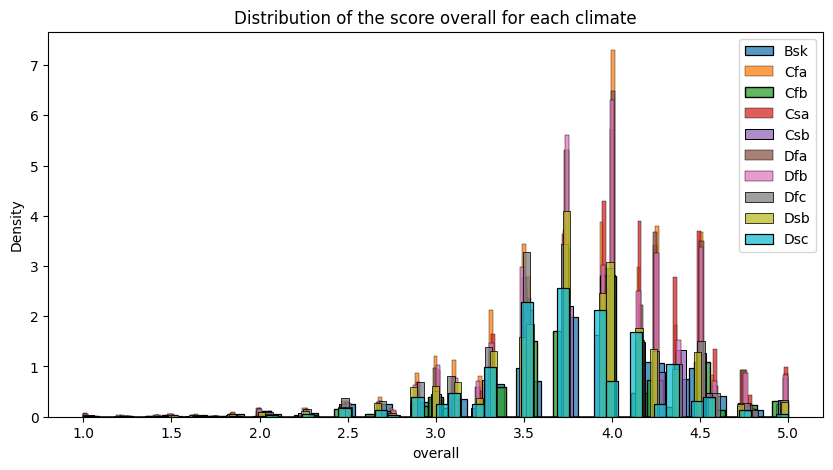

In [124]:
# For one chosen score, plot the distribution of the score for each climate
score = "overall"

# Get the data
data_to_plot = us_users_ratings_scores[["climate", score]].copy()
data_to_plot = data_to_plot.groupby("climate")[score].apply(list).reset_index()

# Plot the data
box_plot = False
if box_plot:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.boxplot(data_to_plot[score])
    ax.set_xticklabels(data_to_plot["climate"])
    ax.set_ylabel(score)
    ax.set_title("Distribution of the score " + score + " for each climate")
else:
    # Use superimposed histograms
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(data_to_plot)):
        sns.histplot(
            data_to_plot[score][i],
            ax=ax,
            label=data_to_plot["climate"][i],
            stat="density",
        )
    ax.set_xlabel(score)
    ax.set_ylabel("Density")
    ax.set_title("Distribution of the score " + score + " for each climate")
    ax.legend()


plt.show()

When we look at the distribution of the different climates, it seems that the distribution are different. However, we need to perform a statistical test to see if the difference is significant.

In [125]:
for score in scores_to_compare:
    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            us_users_ratings_scores[us_users_ratings_scores.climate == zone][score]
            for zone in us_users_ratings_scores.climate.unique()
        ],
        axis=0
    )
    print(score, res[1])

aroma 0.0
appearance 0.0
palate 0.0
taste 0.0
overall 0.0


For all the scores, the one-way ANOVA test is performed to see if the difference is significant. Each time, the null hypothesis is rejected, meaning that the difference is significant. This indicates that the climate has an impact on the ratings but the results are not very interpretable. We need to decompose the climate into its three components: scheme, precipitation and temperature.

## 2.2) Using climate components for grouping

In this second analysis, we are going to decompose the climate into its three components: scheme, precipitation and temperature. We will then perform the same analysis as before to see if the difference is significant.

We start with the temperature:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

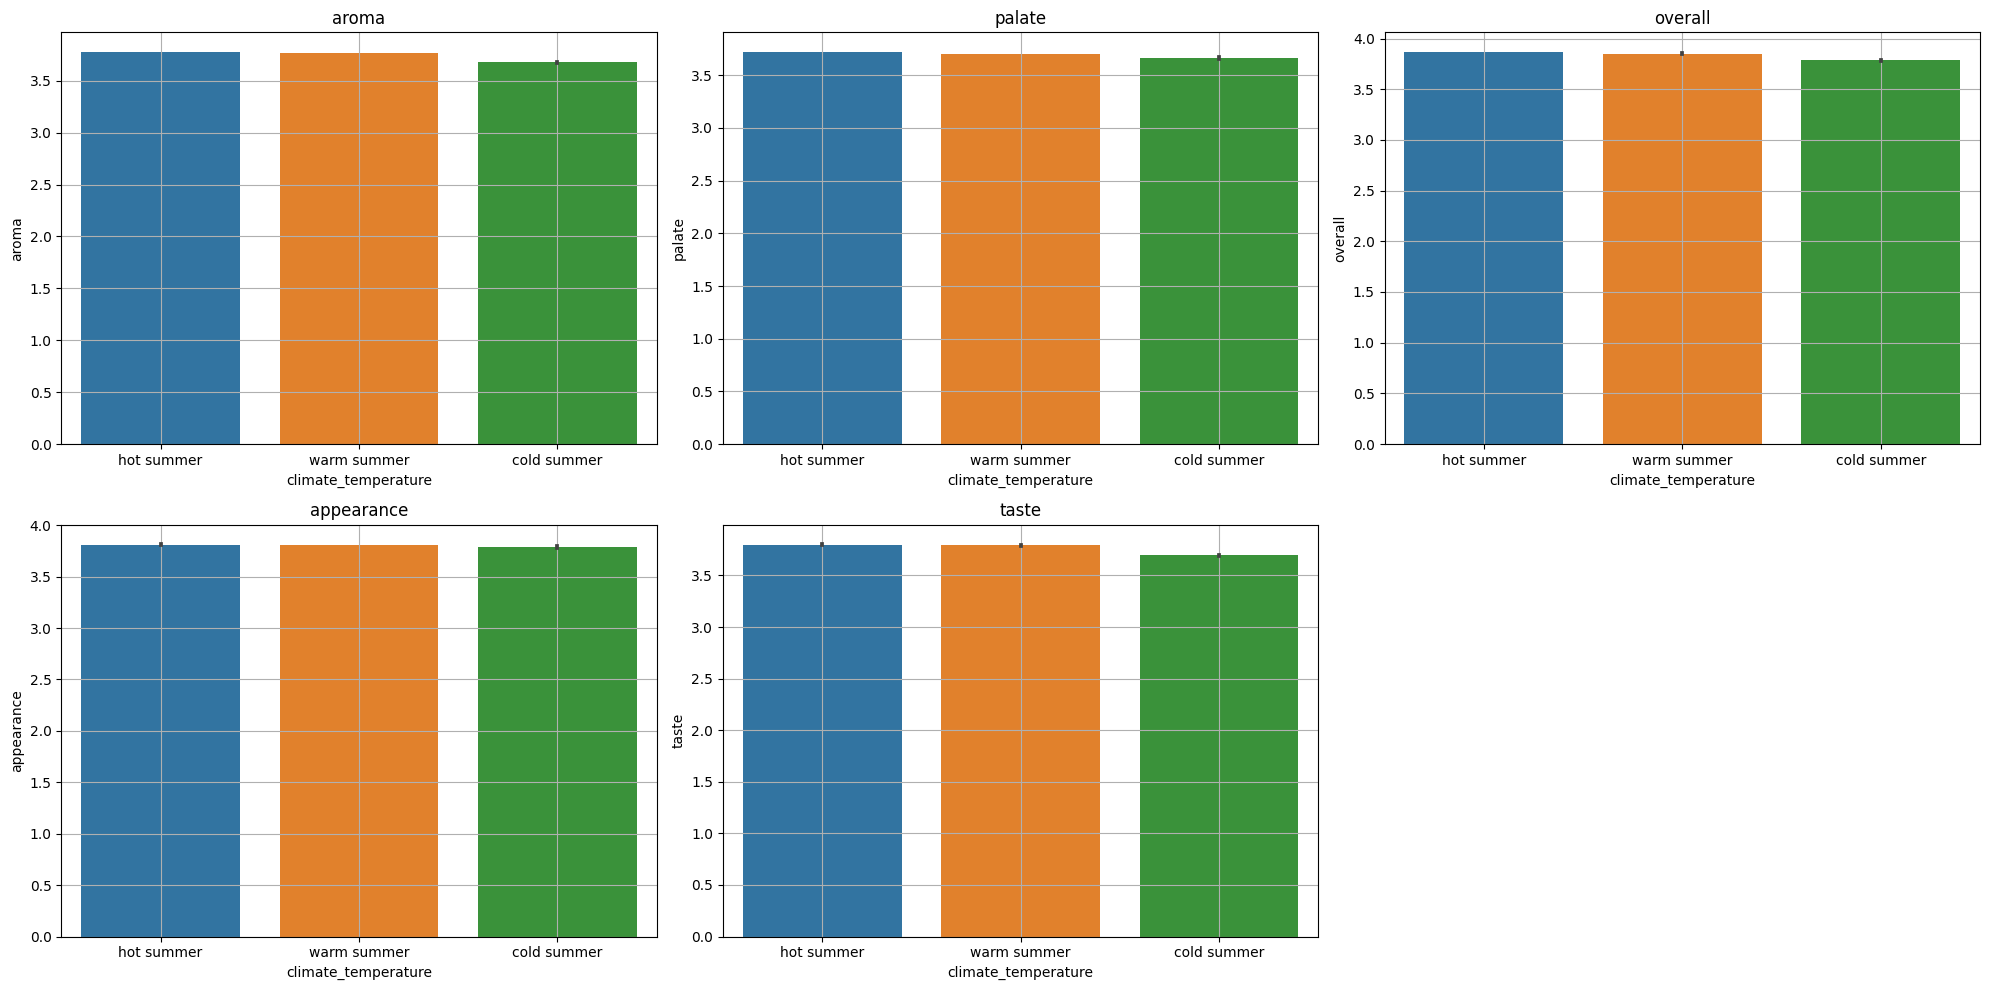

In [126]:
# Plot the average overall score for each climate temp
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    sns.barplot(
        x=us_users_ratings_scores["climate_temperature"],
        y=us_users_ratings_scores[score],
        ax=ax[i % 2, i // 2],
    )
    ax[i % 2, i // 2].set_title(score)
    ax[i % 2, i // 2].grid()

ax[1, 2].axis("off")
plt.tight_layout()
plt.show()

Just looking at these barplots, it does not seem that the temperature has an impact on the ratings. However, we need to perform a statistical test to see if the difference is significant.

In [127]:
for score in scores_to_compare:
    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            us_users_ratings_scores[
                us_users_ratings_scores.climate_temperature == zone
            ][score]
            for zone in us_users_ratings_scores.climate_temperature.unique()
        ],
        axis=0
    )
    print(score, res[1])

aroma 3.9275560591256844e-231
appearance 6.533797653554101e-13
palate 4.290667765342083e-74
taste 9.511391804416189e-250
overall 2.2766902754426052e-197


After performing the one-way ANOVA test, we can see that the difference is significant for the temperature. This means that the temperature does have an impact on the ratings. However, the difference is very small as the following plot shows.

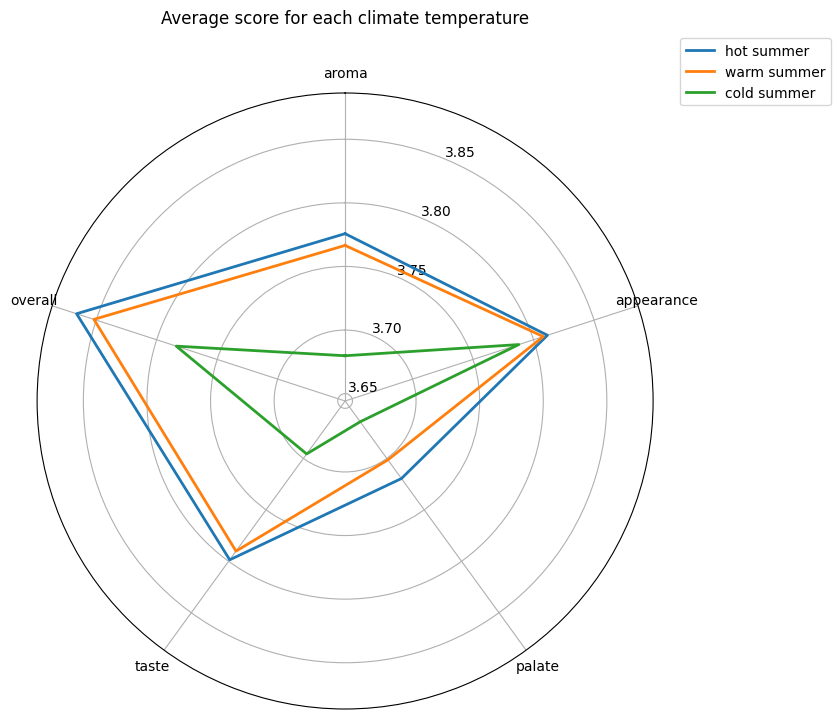

In [128]:
# Now let's analyze but using the climate_temperature column
climate_temperature_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_t in us_users_ratings_scores["climate_temperature"].unique():
    climate_temperature_dfs[climate_t] = us_users_ratings_scores[
        us_users_ratings_scores["climate_temperature"] == climate_t
    ]

    for score in scores_to_compare:
        averages_scores[(climate_t, score)] = climate_temperature_dfs[climate_t][
            score
        ].mean()

spider_plot(
    scores_to_compare,
    averages_scores,
    us_users_ratings_scores["climate_temperature"].unique(),
    title="Average scores for each climate temperature",
)

Here a similar analysis is performed for the precipitation:

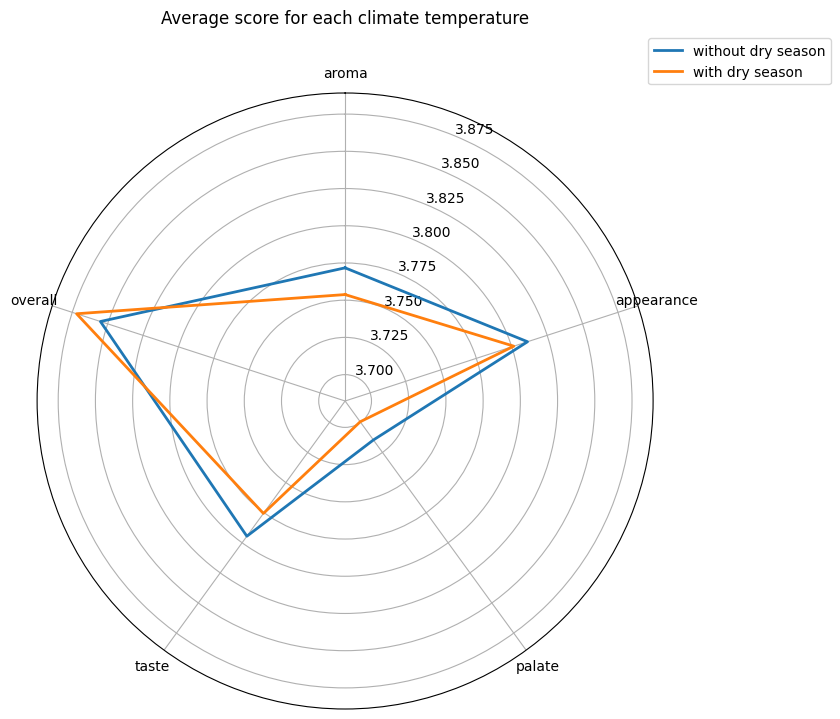

In [129]:
# Now let's analyze but using the climate_temperature column
climate_precipitation_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_prec in us_users_ratings_scores["climate_precipitation"].unique():
    climate_precipitation_dfs[climate_prec] = us_users_ratings_scores[
        us_users_ratings_scores["climate_precipitation"] == climate_prec
    ]

    for score in scores_to_compare:
        averages_scores[(climate_prec, score)] = climate_precipitation_dfs[
            climate_prec
        ][score].mean()

spider_plot(
    scores_to_compare,
    averages_scores,
    us_users_ratings_scores["climate_precipitation"].unique(),
    title="Average scores for each climate precipitation",
)

With the following p-values:

In [130]:
for score in scores_to_compare:
    res = stats.f_oneway(
        *[
            us_users_ratings_scores[
                us_users_ratings_scores.climate_precipitation == zone
            ][score]
            for zone in us_users_ratings_scores.climate_precipitation.unique()
        ],
        axis=0
    )

    print(score, res[1])

aroma 1.826238705456336e-27
appearance 6.047862157396129e-08
palate 2.188714498785996e-15
taste 1.1237054531250214e-28
overall 7.011835650552108e-27


Finally, the same analysis is performed for the scheme:

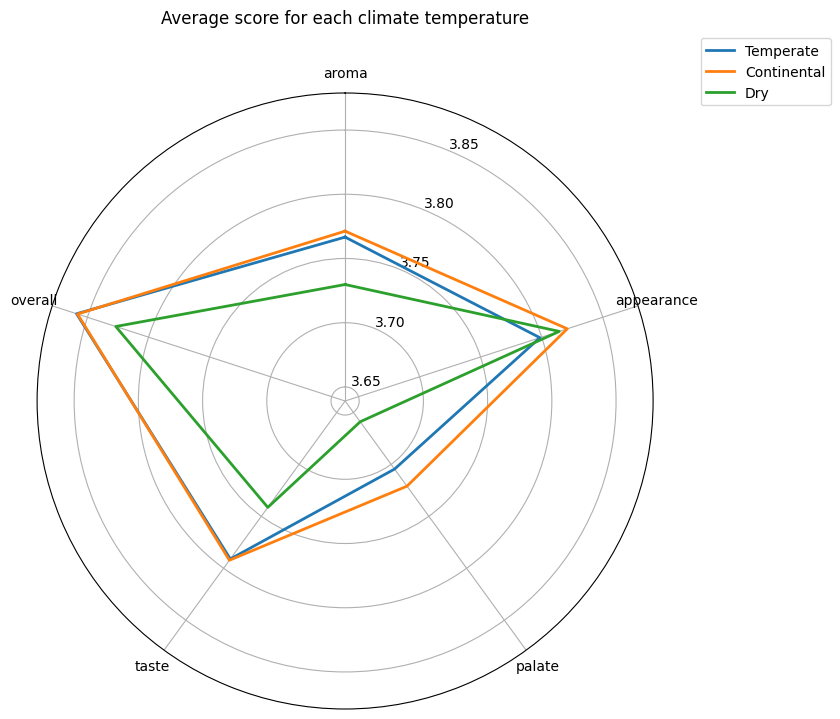

In [131]:
# Now let's analyze but using the climate_scheme column
climate_scheme_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_s in us_users_ratings_scores["climate_scheme"].unique():
    climate_scheme_dfs[climate_s] = us_users_ratings_scores[
        us_users_ratings_scores["climate_scheme"] == climate_s
    ]

    for score in scores_to_compare:
        averages_scores[(climate_s, score)] = climate_scheme_dfs[climate_s][
            score
        ].mean()

spider_plot(
    scores_to_compare,
    averages_scores,
    us_users_ratings_scores["climate_scheme"].unique(),
    title="Average scores for each climate scheme",
)

In [132]:
for score in scores_to_compare:
    res = stats.f_oneway(
        *[
            us_users_ratings_scores[us_users_ratings_scores.climate_scheme == zone][
                score
            ]
            for zone in us_users_ratings_scores.climate_scheme.unique()
        ],
        axis=0
    )

    print(score, res[1])

aroma 1.6617544140786726e-12
appearance 1.9712082985803656e-57
palate 4.153030103535449e-40
taste 8.740468335523494e-15
overall 2.4814665610875236e-07


From the previous results, it appears that indeed climate have a small impact on the appreciation of the beers. However, the difference is very small.

To go more in details, we are now going to study the different beers, mostly which type of beers are liked in the various climates.


# 3) Analysis of the styles of beers

We will look at the styles of beer and see if we can find any interesting patterns by checking for each kind of climates, which styles are the most popular.

In [133]:
us_users_ratings_style = us_users_ratings.copy()

us_users_ratings_style = us_users_ratings_style.dropna(
    subset=["overall", "general_style"]
)

Now that the data are loaded, we can first just look at the beers most liked in the whole US:

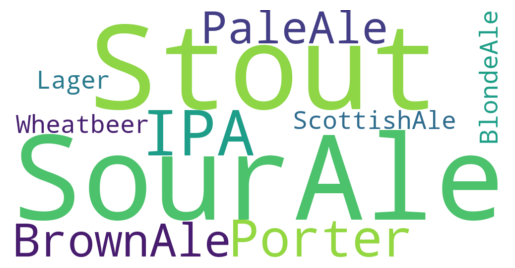

In [134]:
overall_averge_per_beer_type = (
    us_users_ratings_style.groupby(["general_style"])["overall"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)



# Go through "general_style" column and remove the " "


overall_averge_per_beer_type["general_style"] = overall_averge_per_beer_type[
    "general_style"
].str.replace(" ", "")



# Combine the strings into one text


text_combined = " ".join(overall_averge_per_beer_type["general_style"])



# Create and generate a word cloud image:


wordcloud_best_beers = wordcloud.WordCloud(

    width=1000, height=500, background_color="white"
).generate(text_combined)



# Display the generated image:


plt.imshow(wordcloud_best_beers, interpolation="bilinear")



plt.axis("off")


plt.show()

## 3.1) How does the climate of a user impact their preference in beer style?

1. What type of beer do users from each climate prefer? Is there significance?
2. What is the most rated beer from each climate? Is it one they dislike or like strongly?
3. Is the alcohol percentage of the preferred beer significant to the respective climates?

First, we will need to preprocess the `us_users_ratings_style` dataset to add a `general_style` column that is made from the beer's `style` which can be very specific. Then, we need to group the beers by climate to do the analysis to find answers to our questions.  

As there are many different styles of beer, it seems too hard to automate the process of tokenisation. We chose to export the dataframe with the style of beer and manually assign each one to a more general style. The groupings were made based on this reference: https://hospitalityinsights.ehl.edu/beer-types. These are:
- Lager
- Pale Ale
- Blonde Ale
- Brown Ale
- IPA
- Wheatbeer
- Porter
- Stout
- Sour Ale
- Scottish Ale

In [135]:
# get all styles of beers to regroup them by general types

beer_styles = us_users_ratings_style[["style"]].copy()
beer_styles = beer_styles.drop_duplicates()
# beer_styles.to_excel(r'beer_style.xlsx', index=False)

print("There are {} different beer styles in the dataset".format(len(beer_styles)))
beer_styles.head()

There are 103 different beer styles in the dataset


,style
7,English Pale Ale
78,English Bitter
127,English India Pale Ale (IPA)
167,American Amber / Red Ale
173,American Double / Imperial IPA


In [136]:
general_beer_types = us_users_ratings_style["general_style"].unique()

print(
    "There are {} different general beer styles in the dataset".format(
        len(general_beer_types)
    )
)
print(general_beer_types)
us_users_ratings_style.head()

There are 10 different general beer styles in the dataset
['Pale Ale' 'IPA' 'Porter' 'Blonde Ale' 'Scottish Ale ' 'Lager'
 'Wheat beer' 'Sour Ale' 'Stout' 'Brown Ale']


,beer_id,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,...,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style
7,19827,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,...,5,5,North Carolina,264.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
8,19827,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,...,5,5,New York,2314.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
11,19827,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,...,5,5,Illinois,585.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale
13,19827,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,...,5,5,Massachusetts,1315.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale
14,19827,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,...,5,5,North Carolina,6306.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale


We will first look for each climate which are the most liked beers (according to the score `overall` given by the users) and which beers are the most reviewed.

In [137]:
# Find for each climate the most liked beer style
climate_beer_type = (
    us_users_ratings_style.groupby(["climate", "general_style"])["overall"]
    .mean()
    .reset_index()
)

# Create a datafram which gives for each climate the general style ordered by the average overall rating
columns = ["climate"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate = pd.DataFrame(columns=columns)

for climate in climate_beer_type["climate"].unique():
    best_beers_per_climate.loc[climate] = [climate] + list(
        climate_beer_type[climate_beer_type["climate"] == climate]
        .sort_values(by="overall", ascending=False)["general_style"]
        .values[:10]
    )

display(best_beers_per_climate)

# Can compute average position for each beer type in the top 10 for each climate
best_beers_average_position = {}

for row in best_beers_per_climate.iterrows():
    for i, beer in enumerate(row[1][1:]):
        if beer in best_beers_average_position:
            best_beers_average_position[beer] += i + 1
        else:
            best_beers_average_position[beer] = i + 1

for beer in best_beers_average_position:
    best_beers_average_position[beer] /= len(best_beers_per_climate)

print("The average position of each beer type in the top 10 for each climate is:")
print(best_beers_average_position)

,climate,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Bsk,Bsk,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Blonde Ale,Wheat beer,Lager
Cfa,Cfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager
Cfb,Cfb,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Lager,Scottish Ale,Blonde Ale
Csa,Csa,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Blonde Ale,Wheat beer,Lager
Csb,Csb,Sour Ale,Stout,Porter,IPA,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Lager,Blonde Ale
Dfa,Dfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Wheat beer,Blonde Ale,Scottish Ale,Lager
Dfb,Dfb,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
Dfc,Dfc,Sour Ale,Stout,Porter,IPA,Brown Ale,Scottish Ale,Wheat beer,Pale Ale,Blonde Ale,Lager
Dsb,Dsb,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Scottish Ale,Blonde Ale,Lager
Dsc,Dsc,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager


The average position of each beer type in the top 10 for each climate is:
{'Sour Ale': 1.0, 'Stout': 2.0, 'IPA': 3.2, 'Porter': 3.8, 'Brown Ale': 5.0, 'Scottish Ale ': 7.0, 'Pale Ale': 6.8, 'Blonde Ale': 8.9, 'Wheat beer': 7.6, 'Lager': 9.7}


We repeat but looking at the most reviewed beers.

In [138]:
most_reviewed_per_climate = pd.DataFrame(columns=columns)

for climate in climate_beer_type["climate"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate.loc[climate] = [climate] + list(
        us_users_ratings_style[us_users_ratings_style["climate"] == climate]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )

display(most_reviewed_per_climate)

most_reviewed_position = {}

for row in most_reviewed_per_climate.iterrows():
    for i, beer in enumerate(row[1][1:]):
        if beer in most_reviewed_position:
            most_reviewed_position[beer] += i + 1
        else:
            most_reviewed_position[beer] = i + 1

for beer in most_reviewed_position:
    most_reviewed_position[beer] /= len(best_beers_per_climate)

print("The average position of each beer type in the top 10 for each climate is:")
print(most_reviewed_position)

,climate,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Bsk,Bsk,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Cfa,Cfa,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Cfb,Cfb,IPA,Pale Ale,Brown Ale,Porter,Lager,Stout,Wheat beer,Sour Ale,Blonde Ale,Scottish Ale
Csa,Csa,IPA,Pale Ale,Brown Ale,Porter,Sour Ale,Stout,Lager,Wheat beer,Blonde Ale,Scottish Ale
Csb,Csb,IPA,Pale Ale,Porter,Brown Ale,Lager,Stout,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dfa,Dfa,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dfb,Dfb,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dfc,Dfc,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dsb,Dsb,IPA,Pale Ale,Porter,Brown Ale,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dsc,Dsc,IPA,Pale Ale,Porter,Brown Ale,Lager,Stout,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale


The average position of each beer type in the top 10 for each climate is:
{'IPA': 1.0, 'Pale Ale': 2.0, 'Brown Ale': 3.3, 'Porter': 3.7, 'Stout': 5.4, 'Lager': 5.8, 'Sour Ale': 6.9, 'Wheat beer': 7.9, 'Blonde Ale': 9.0, 'Scottish Ale ': 10.0}


Now, let's plot the two:

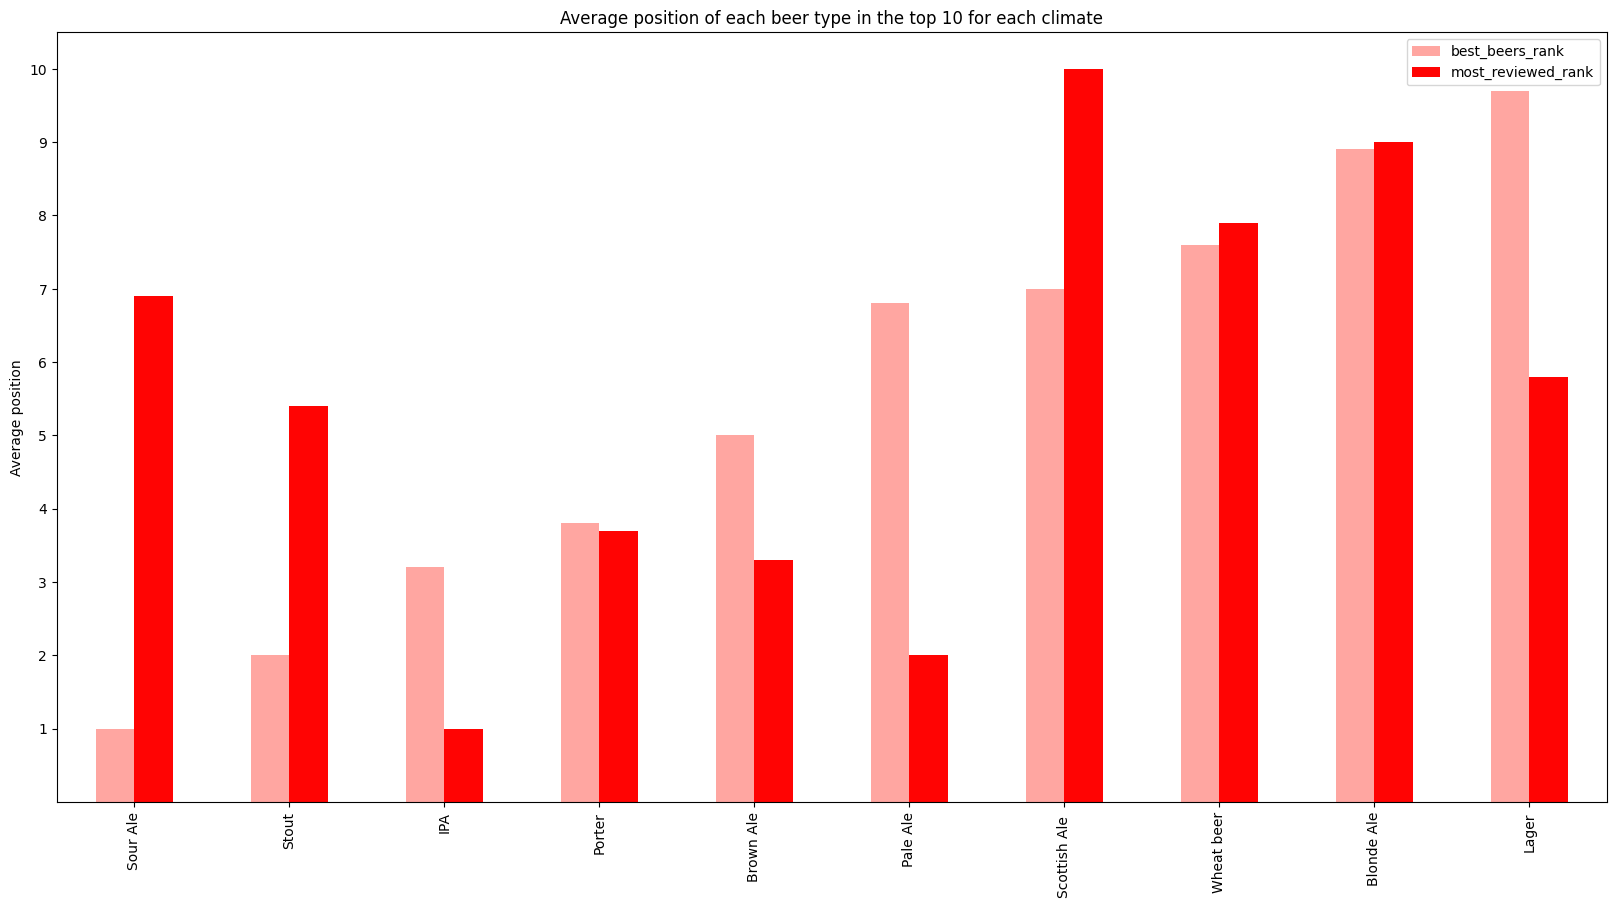

In [139]:
positions_per_beer = pd.DataFrame(
    columns=["beer_type", "best_beers_rank", "most_reviewed_rank"]
)



for beer in best_beers_average_position:
    positions_per_beer.loc[beer] = [
        beer,
        best_beers_average_position[beer],
        most_reviewed_position[beer],
    ]



positions_per_beer = positions_per_beer.sort_values(
    by="best_beers_rank", ascending=True
)



# Plot the two rankings for each beer type using barplot


fig, ax = plt.subplots(figsize=(20, 10))



light_red = "#FFA6A1"


dark_red = "#FF0403"


positions_per_beer.plot.bar(ax=ax, color=[light_red, dark_red])


ax.set_ylabel("Average position")


ax.set_title("Average position of each beer type in the top 10 for each climate")


ax.set_yticks(np.arange(1, 11))


plt.show()

We can also plot them nicely:

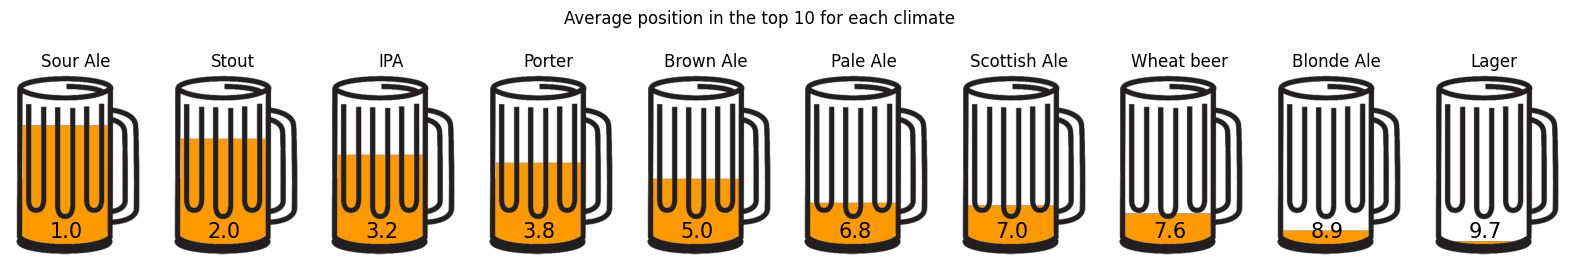

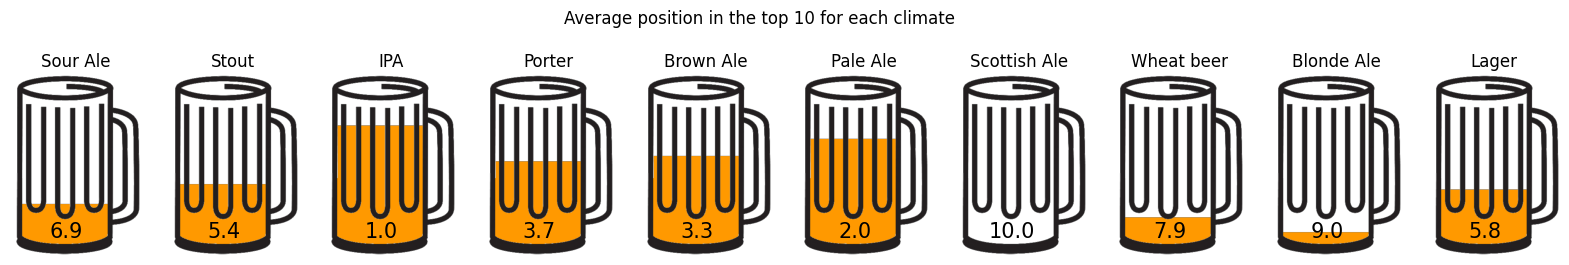

In [140]:
plot_on_beers(
    positions_per_beer,
    "best_beers_rank",
    "beer_type",
    "Average position in the top 10 for each climate",
)


plot_on_beers(
    positions_per_beer,
    "most_reviewed_rank",
    "beer_type",
    "Average position in the top 10 for each climate",
)

The ordering of the various beers is clearly not the same, but it is interesting to check the actual ratings they got:

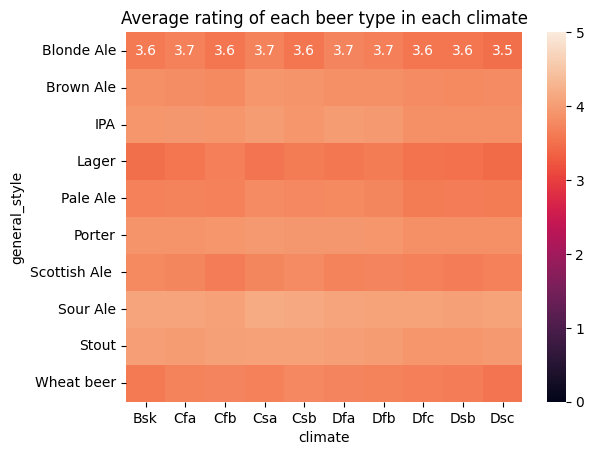

In [141]:
# heatmap of the ratings given to each beer type in each climate

df = pd.crosstab(
    climate_beer_type["general_style"],
    climate_beer_type["climate"],
    values=climate_beer_type["overall"],
    aggfunc="mean",
)
sns.heatmap(df, annot=True, vmin=0, vmax=5)
plt.title("Average rating of each beer type in each climate")
plt.show()

There doesn't seem to be a big difference between the ratings between the climates. There do seem to be types of beers that are generally preferred than others. Let's try to analyse these results in a bit more detail to look for significant differences. For example, the Dsc climate seems to have the most variety in results so we can explore this one first.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

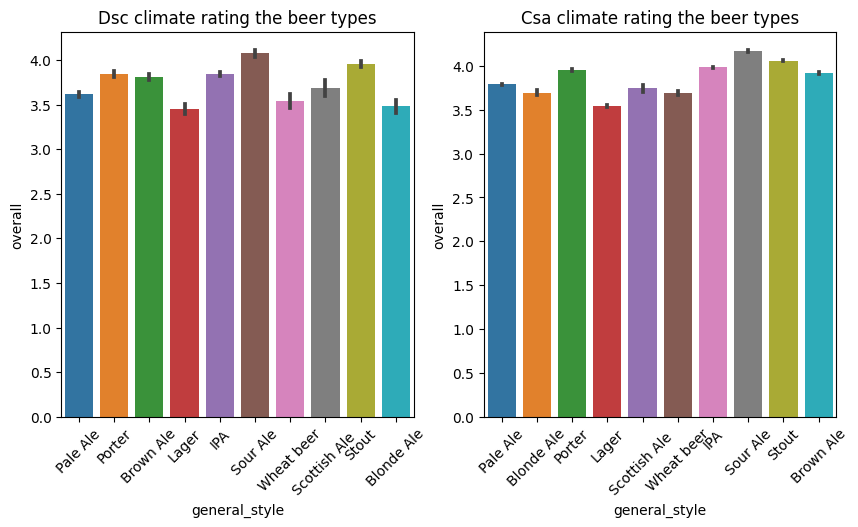

In [142]:
# view the average rating per beer type in Dsc and Csa

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

plot_1 = sns.barplot(
    x="general_style",
    y="overall",
    data=us_users_ratings_style[us_users_ratings_style["climate"] == "Dsc"],
    ax=ax0,
)
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)
plot_1.set_title("Dsc climate rating the beer types")

plot_2 = sns.barplot(
    x="general_style",
    y="overall",
    data=us_users_ratings_style[us_users_ratings_style["climate"] == "Csa"],
    ax=ax1,
)
plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=45)
plot_2.set_title("Csa climate rating the beer types")

plt.show()

In [143]:
# For each climate, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different
# H0: the two variables are independent

for climate in us_users_ratings_style["climate"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings_style[
                us_users_ratings_style["general_style"] == beer_type
            ]["overall"]
            for beer_type in us_users_ratings_style["general_style"].unique()
        ]
    )

    print("For the climate {}, the p-value is {}".format(climate, res.pvalue))

For the climate Cfa, the p-value is 0.0
For the climate Dfa, the p-value is 0.0
For the climate Cfb, the p-value is 0.0
For the climate Dfb, the p-value is 0.0
For the climate Dfc, the p-value is 0.0
For the climate Csb, the p-value is 0.0
For the climate Csa, the p-value is 0.0
For the climate Dsc, the p-value is 0.0
For the climate Dsb, the p-value is 0.0
For the climate Bsk, the p-value is 0.0


All p-values are below 0.05, so we can reject the null hypothesis and conclude that there is a significant difference between the ratings of the different beers in each climate.

We can now look at the overall score for each beer across all climates:

In [144]:
# Microaverage: compute the mean overall rating for all users
micro_av_overall = us_users_ratings_style["overall"].mean()
print("The micro average overall rating is {:.4f}".format(micro_av_overall))

# Macroaverage: compute statistics for each climate, then take the mean
climate_av_overall = (
    us_users_ratings_style.groupby("climate")["overall"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
climate_av_overall.set_index("climate", inplace=True)
macro_av_overall = climate_av_overall["overall"].mean()
print("The macro average overall rating is {:.4f}".format(macro_av_overall))

The micro average overall rating is 3.8582
The macro average overall rating is 3.8342


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

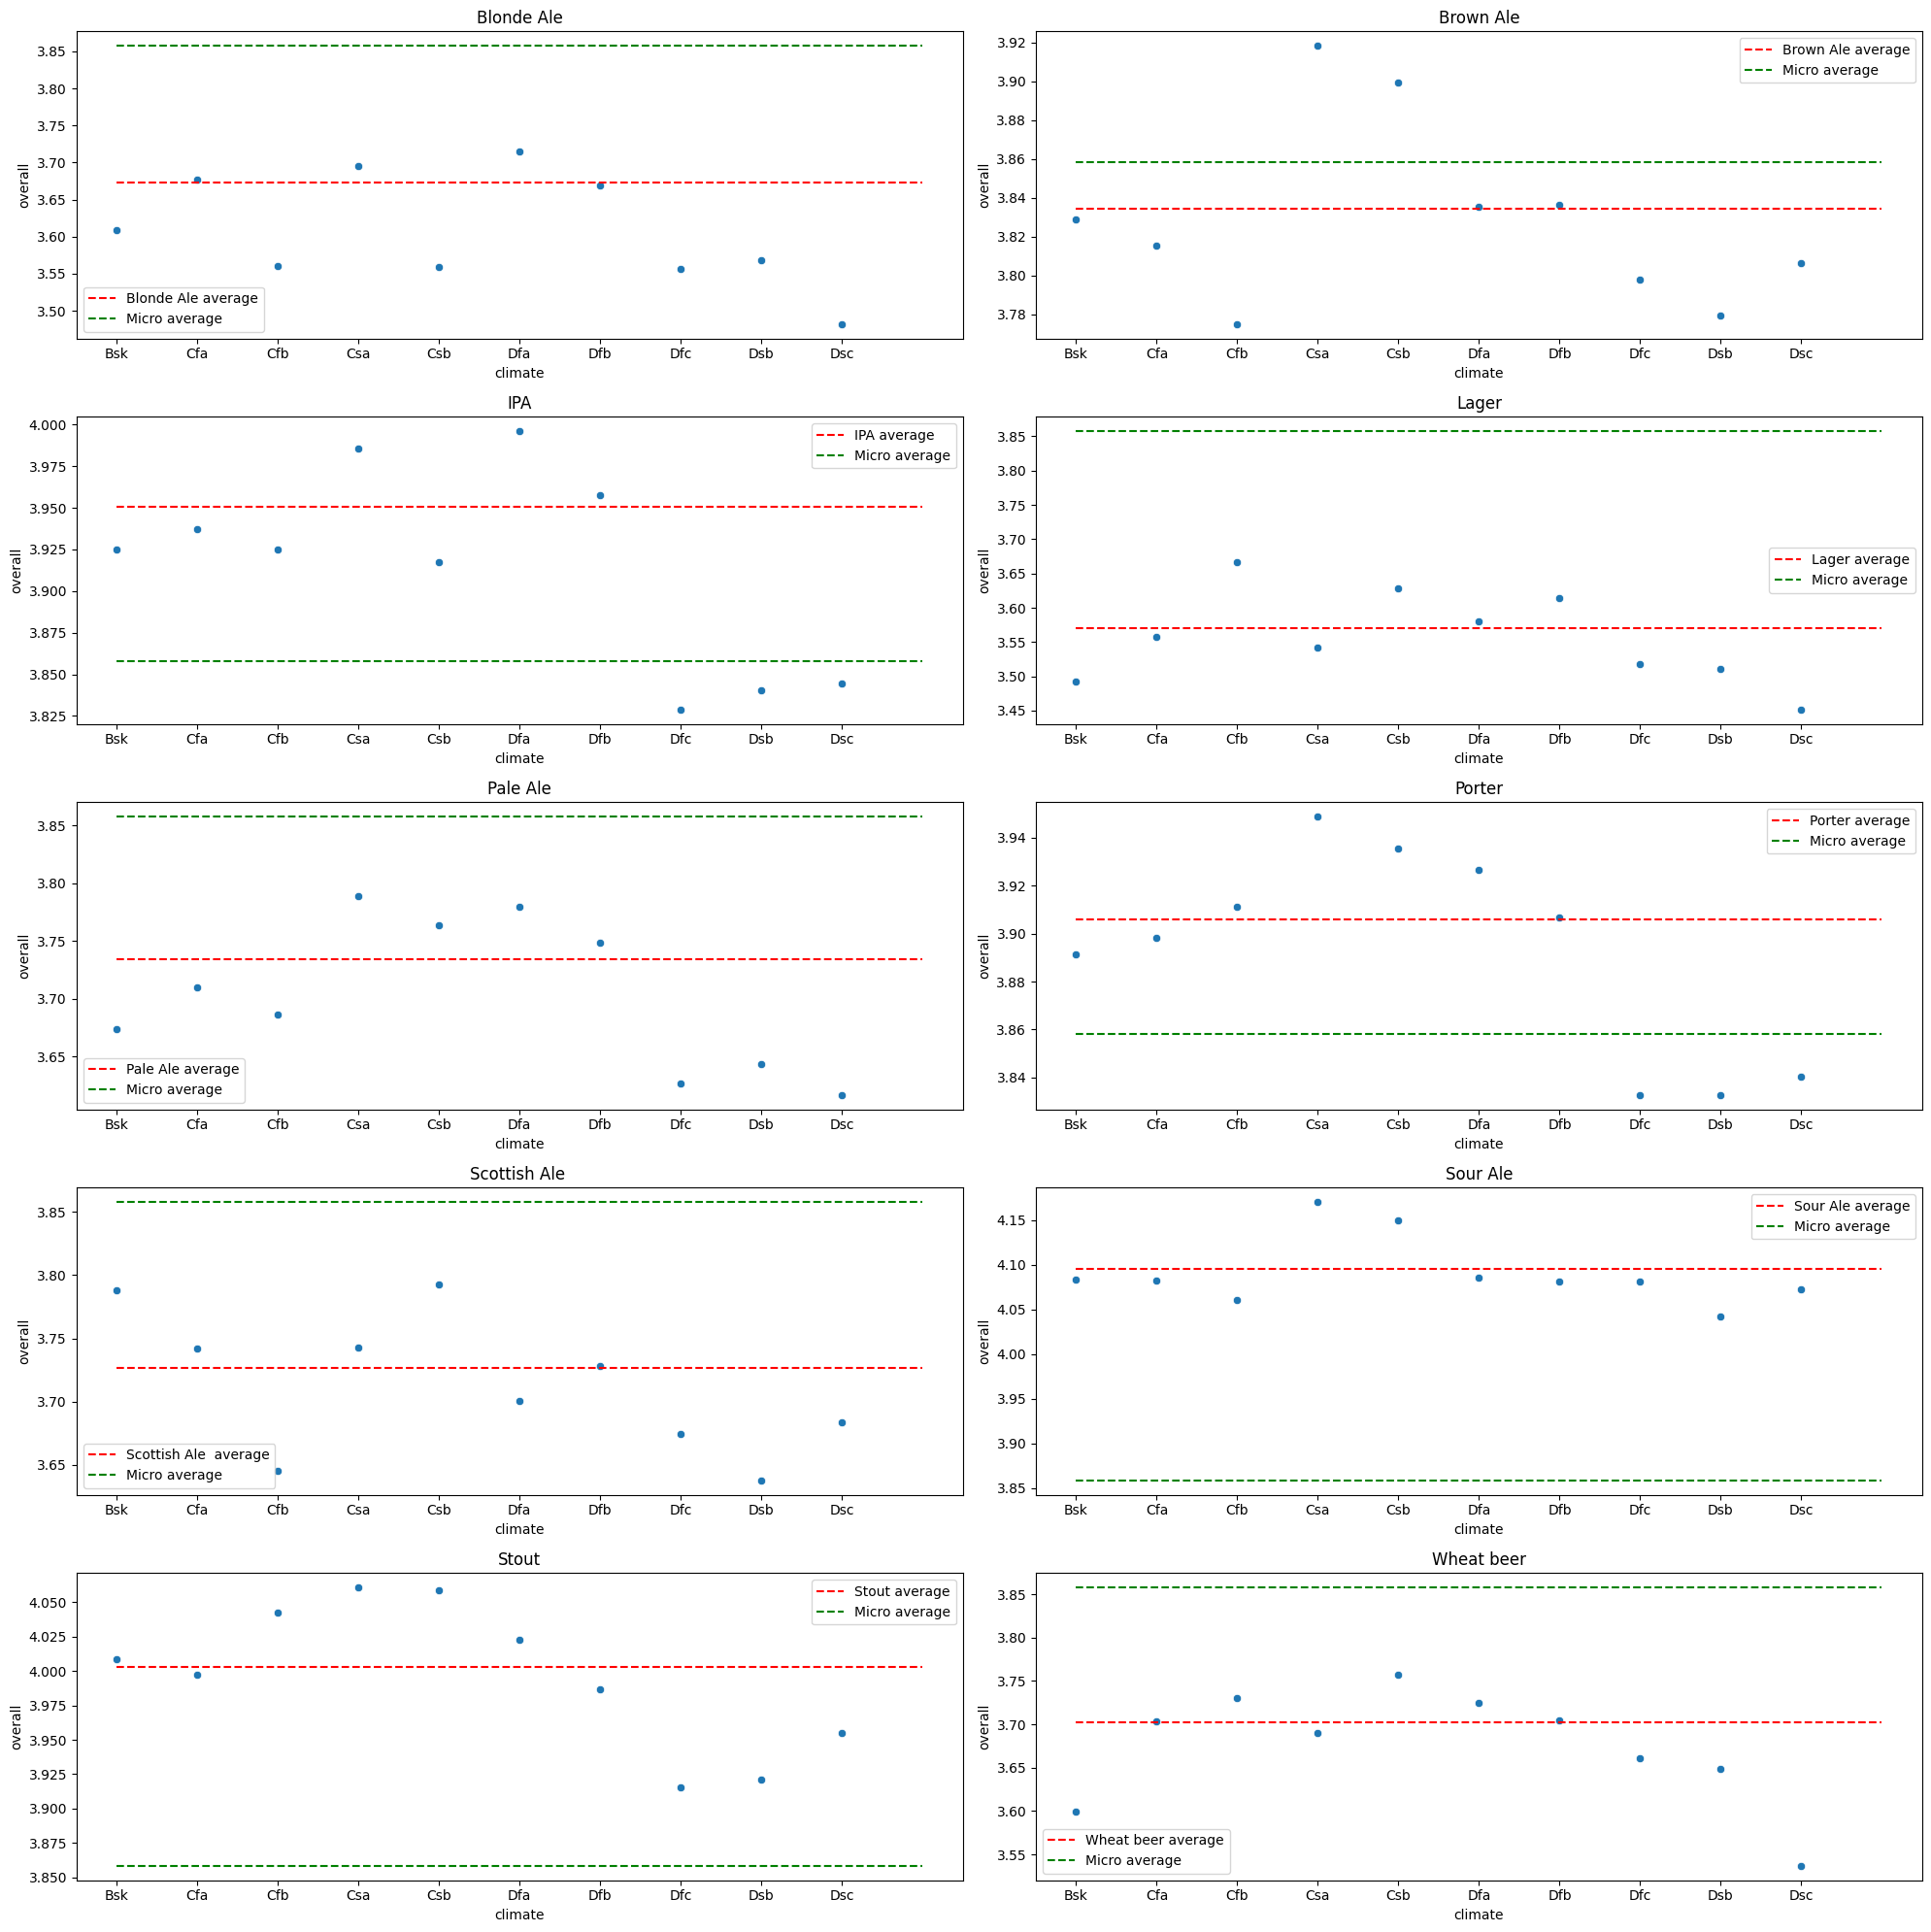

In [145]:
# Plot the different beer type means as a function of the climate for all beers

num_scores = len(climate_beer_type["climate"].unique())
fig, axs = plt.subplots(num_scores // 2, 2, figsize=(20, 20))

for i, beer_type in enumerate(climate_beer_type["general_style"].unique()):
    # compute average beer rating for that beer type
    beer_type_av_overall = us_users_ratings_style[
        us_users_ratings_style["general_style"] == beer_type
    ]["overall"].mean()

    # plot the overall beer ratings for each type, climate and the different averagers
    ax = axs[i // 2, i % 2]
    sns.scatterplot(
        x="climate",
        y="overall",
        data=us_users_ratings_style[
            us_users_ratings_style["general_style"] == beer_type
        ]
        .groupby("climate")["overall"]
        .mean()
        .reset_index(),
        ax=ax,
    )

    ax.set_title(beer_type)
    ax.plot(
        [0, num_scores],
        [beer_type_av_overall, beer_type_av_overall],
        "r--",
        label="{} average".format(beer_type),
    )
    ax.plot(
        [0, num_scores],
        [micro_av_overall, micro_av_overall],
        "g--",
        label="Micro average",
    )

    ax.legend()

plt.tight_layout()
plt.show()

In [146]:
# Compute a one-way ANOVA test for each beer type to see if the ratings given to each beer type are significantly different
for beer_type in us_users_ratings_style["general_style"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings_style[us_users_ratings_style["climate"] == climate][
                "overall"
            ]
            for climate in us_users_ratings_style["climate"].unique()
        ]
    )

    print("For the beer type {}, the p-value is {}".format(beer_type, res.pvalue))

For the beer type Pale Ale, the p-value is 0.0
For the beer type IPA, the p-value is 0.0
For the beer type Porter, the p-value is 0.0
For the beer type Blonde Ale, the p-value is 0.0
For the beer type Scottish Ale , the p-value is 0.0
For the beer type Lager, the p-value is 0.0
For the beer type Wheat beer, the p-value is 0.0
For the beer type Sour Ale, the p-value is 0.0
For the beer type Stout, the p-value is 0.0
For the beer type Brown Ale, the p-value is 0.0


The three averages are:
- beer average: moyenne des averages pour ce type de biere
- macro average: moyenne des averages par climat de toutes les bieres
- micro average: moyenne de tous les averages

It can be noted that the beer macro and micro averages are very similar for Wheat beer, Stout and Lager. This means that the average rating per climate is the same as the average rating overall ie. could be the same distribution or they compensate each other.

Furthermore, From these visualisations, the beers look to be in three main categories:
- beers that are rated better than the micro/macro averages (Stout, Sour Ale)
- beers that are rated better than the micro/macro averages (Wheat Beer,Lager, Blonde Ale, Scottish Ale, Pale Ale)
- beers with ratings that fluctuate around the micro/macro averages (Porter, IPA, Brown Ale)

## 3.2) Analysis of the beers per sub-climate

As in the score part, we will look at the beers per sub-climate to see if there are any significant differences between the ratings of the beers. For each, we will check the most liked and most reviewed beers.

In [147]:
# Now let's analyse the scheme of the climate and the overall rating
columns = ["climate_scheme"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_scheme = pd.DataFrame(columns=columns)
amount_reviews_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_users_ratings_style["climate_scheme"].unique():
    row = [climate_scheme] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_scheme"] == climate_scheme
        ]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_scheme.loc[len(best_beers_per_climate_scheme)] = row
    amount_reviews_per_climate_scheme.loc[len(amount_reviews_per_climate_scheme)] = [
        climate_scheme
    ] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_scheme"] == climate_scheme
        ]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_scheme)
display(amount_reviews_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager
1,Continental,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Wheat beer,Scottish Ale,Blonde Ale,Lager
2,Dry,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Blonde Ale,Wheat beer,Lager


,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,118267,79628,54961,50771,39179,35466,32429,17208,11077,3920
1,Continental,115496,74989,48768,46117,35882,33047,27276,15328,10154,3225
2,Dry,2777,1826,1050,1008,818,720,656,324,270,102


In [148]:
# For each climate scheme, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different
for climate_scheme in us_users_ratings_style["climate_scheme"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings_style[
                us_users_ratings_style["general_style"] == beer_type
            ]["overall"]
            for beer_type in us_users_ratings_style["general_style"].unique()
        ]
    )

    print(
        "For the climate scheme {}, the p-value is {}".format(
            climate_scheme, res.pvalue
        )
    )

For the climate scheme Temperate, the p-value is 0.0
For the climate scheme Continental, the p-value is 0.0
For the climate scheme Dry, the p-value is 0.0


In [149]:
# Let's look at the most reviewed beers for each climate scheme
columns = ["climate_scheme"] + ["beer_" + str(i) for i in range(1, 11)]
most_reviewed_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_users_ratings_style["climate_scheme"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate_scheme.loc[climate_scheme] = [climate_scheme] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_scheme"] == climate_scheme
        ]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )

display(most_reviewed_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Temperate,Temperate,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Continental,Continental,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dry,Dry,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale


It seems like there are no differences of positions between the beers in the different climate schemes, we look at the precitation and temperature of the climates to see if there are any differences.

In [150]:
# Now let's analyse the precipitation of the climate and the overall rating
columns = ["climate_precipitation"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_precipitation = pd.DataFrame(columns=columns)
amount_reviews_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_users_ratings_style["climate_precipitation"].unique():
    row = [climate_precipitation] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_precipitation"] == climate_precipitation
        ]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_precipitation.loc[
        len(best_beers_per_climate_precipitation)
    ] = row
    amount_reviews_per_climate_precipitation.loc[
        len(amount_reviews_per_climate_precipitation)
    ] = [climate_precipitation] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_precipitation"] == climate_precipitation
        ]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_precipitation)
display(amount_reviews_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
1,with dry season,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager


,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,193030,127289,85636,79826,62664,58322,47270,27701,17874,5822
1,with dry season,43510,29154,19143,18070,13215,13091,10911,5159,3627,1425


In [151]:
# For each climate precipitation, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different

for climate_precipitation in us_users_ratings_style["climate_precipitation"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings_style[
                us_users_ratings_style["general_style"] == beer_type
            ]["overall"]
            for beer_type in us_users_ratings_style["general_style"].unique()
        ]
    )

    print(
        "For the climate precipitation {}, the p-value is {}".format(
            climate_precipitation, res.pvalue
        )
    )

For the climate precipitation without dry season, the p-value is 0.0
For the climate precipitation with dry season, the p-value is 0.0


In [152]:
# Let's look at the most reviewed beers for each climate precipitation
columns = ["climate_precipitation"] + ["beer_" + str(i) for i in range(1, 11)]
most_reviewed_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_users_ratings_style["climate_precipitation"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate_precipitation.loc[climate_precipitation] = [
        climate_precipitation
    ] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_precipitation"] == climate_precipitation
        ]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )

display(most_reviewed_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
without dry season,without dry season,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
with dry season,with dry season,IPA,Pale Ale,Brown Ale,Porter,Stout,Sour Ale,Lager,Wheat beer,Blonde Ale,Scottish Ale


Finally, we can look at the average ratings of the beers per climate temperature:

In [153]:
# Now let's analyse the temperature of the climate and the overall rating
columns = ["climate_temperature"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_temperature = pd.DataFrame(columns=columns)
amount_reviews_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_users_ratings_style["climate_temperature"].unique():
    row = [climate_temperature] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_temperature"] == climate_temperature
        ]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_temperature.loc[
        len(best_beers_per_climate_temperature)
    ] = row
    amount_reviews_per_climate_temperature.loc[
        len(amount_reviews_per_climate_temperature)
    ] = [climate_temperature] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_temperature"] == climate_temperature
        ]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_temperature)
display(amount_reviews_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
1,warm summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
2,cold summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager


,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,159978,105150,71037,65445,52281,46810,41979,22548,14917,4855
1,warm summer,65316,43141,28098,27314,20041,19006,15359,8684,5552,1894
2,cold summer,11246,8152,5644,5137,3557,3417,3023,1628,1032,498


In [154]:
# For each climate temperature, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different

for climate_temperature in us_users_ratings_style["climate_temperature"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings_style[
                us_users_ratings_style["general_style"] == beer_type
            ]["overall"]
            for beer_type in us_users_ratings_style["general_style"].unique()
        ]
    )

    print(
        "For the climate temperature {}, the p-value is {}".format(
            climate_temperature, res.pvalue
        )
    )

For the climate temperature hot summer, the p-value is 0.0
For the climate temperature warm summer, the p-value is 0.0
For the climate temperature cold summer, the p-value is 0.0


In [155]:
# Let's look at the most reviewed beers for each climate temperature
columns = ["climate_temperature"] + ["beer_" + str(i) for i in range(1, 11)]
most_reviewed_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_users_ratings_style["climate_temperature"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate_temperature.loc[climate_temperature] = [
        climate_temperature
    ] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_temperature"] == climate_temperature
        ]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )

display(most_reviewed_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
hot summer,hot summer,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
warm summer,warm summer,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
cold summer,cold summer,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale


There is no clear pattern between the beers and the climates, so we can conclude that the climate does not have a significant impact on the kind of beers liked.

We will also look at the original `style` column to see if there are any differences between the beers in the different climates.

In [156]:
# Now let's analyse the scheme of the climate and the overall rating
columns = ["climate_scheme"] + ["beer_" + str(i) for i in range(1, 6)]

best_beers_per_climate_scheme = pd.DataFrame(columns=columns)
amount_reviews_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_users_ratings_style["climate_scheme"].unique():
    row = [climate_scheme] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_scheme"] == climate_scheme
        ]
        .groupby(["style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["style"]
        .values[:5]
    )
    best_beers_per_climate_scheme.loc[len(best_beers_per_climate_scheme)] = row
    amount_reviews_per_climate_scheme.loc[len(amount_reviews_per_climate_scheme)] = [
        climate_scheme
    ] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_scheme"] == climate_scheme
        ]
        .groupby(["style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:5]
    )

display(best_beers_per_climate_scheme)
display(amount_reviews_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5
0,Temperate,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial Stout,American Wild Ale
1,Continental,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial IPA,American Double / Imperial Stout
2,Dry,Faro,Gueuze,Euro Strong Lager,Lambic - Fruit,Quadrupel (Quad)


,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5
0,Temperate,58948,39742,25068,24087,20375
1,Continental,55754,41413,25726,21208,16869
2,Dry,1489,821,556,430,428


In [157]:
# Now let's analyse the precipitation of the climate and the overall rating
columns = ["climate_precipitation"] + ["beer_" + str(i) for i in range(1, 6)]

best_beers_per_climate_precipitation = pd.DataFrame(columns=columns)
amount_reviews_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_users_ratings_style["climate_precipitation"].unique():
    row = [climate_precipitation] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_precipitation"] == climate_precipitation
        ]
        .groupby(["style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["style"]
        .values[:5]
    )
    best_beers_per_climate_precipitation.loc[
        len(best_beers_per_climate_precipitation)
    ] = row
    amount_reviews_per_climate_precipitation.loc[
        len(amount_reviews_per_climate_precipitation)
    ] = [climate_precipitation] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_precipitation"] == climate_precipitation
        ]
        .groupby(["style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:5]
    )

display(best_beers_per_climate_precipitation)
display(amount_reviews_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5
0,without dry season,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial IPA,American Double / Imperial Stout
1,with dry season,Gueuze,Lambic - Fruit,Quadrupel (Quad),American Double / Imperial Stout,American Wild Ale


,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5
0,without dry season,92956,68279,41627,37094,29014
1,with dry season,23235,13697,9612,8742,8658


In [158]:
# Now let's analyse the temperature of the climate and the overall rating
columns = ["climate_temperature"] + ["beer_" + str(i) for i in range(1, 6)]

best_beers_per_climate_temperature = pd.DataFrame(columns=columns)
amount_reviews_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_users_ratings_style["climate_temperature"].unique():
    row = [climate_temperature] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_temperature"] == climate_temperature
        ]
        .groupby(["style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["style"]
        .values[:5]
    )
    best_beers_per_climate_temperature.loc[
        len(best_beers_per_climate_temperature)
    ] = row
    amount_reviews_per_climate_temperature.loc[
        len(amount_reviews_per_climate_temperature)
    ] = [climate_temperature] + list(
        us_users_ratings_style[
            us_users_ratings_style["climate_temperature"] == climate_temperature
        ]
        .groupby(["style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:5]
    )

display(best_beers_per_climate_temperature)
display(amount_reviews_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5
0,hot summer,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial Stout,American Double / Imperial IPA
1,warm summer,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial IPA,Lambic - Unblended
2,cold summer,Gueuze,Lambic - Fruit,Quadrupel (Quad),American Double / Imperial Stout,American Wild Ale


,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5
0,hot summer,77389,56663,33973,32056,26206
1,warm summer,32697,22288,14123,11994,9524
2,cold summer,6105,3025,2656,2273,1942


Again, there is almost no variability between the beers in the different climates, so we can conclude that the climate does not have a significant impact on the kind of beers liked.

This leads us to investigate again on why the ratings of the different beers are so different. We will look at the alcohol percentage of the beers to see if there is a correlation between the alcohol percentage and the ratings. Let's take a look at the abv per beer style:

In [159]:
# keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings_style["abv"].quantile(0.05)
quantile_95 = us_users_ratings_style["abv"].quantile(0.95)

print("5th percentile:", quantile_5)
print("95th percentile:", quantile_95)

us_abv_ratings = us_users_ratings_style[
    (us_users_ratings_style["abv"] >= quantile_5)
    & (us_users_ratings_style["abv"] <= quantile_95)
]

5th percentile: 4.5
95th percentile: 11.0


We will try to plot them nicely:

In [160]:
# For each beer type, find the 25th and 75th percentile of the abv
abv_percentiles_per_beer_type = {}
for beer_type in general_beer_types:
    abv_percentiles_per_beer_type[beer_type] = (
        us_abv_ratings[us_abv_ratings["general_style"] == beer_type]["abv"]
        .quantile([0.25, 0.75])
        .values
    )

print("The 25th and 75th percentiles of the abv for each beer type are:")
print(abv_percentiles_per_beer_type)

The 25th and 75th percentiles of the abv for each beer type are:
{'Pale Ale': array([5.2, 7. ]), 'IPA': array([6.5, 8.2]), 'Porter': array([6.5, 9.5]), 'Blonde Ale': array([4.6, 5.3]), 'Scottish Ale ': array([6.3, 8.1]), 'Lager': array([5., 6.]), 'Wheat beer': array([5. , 6.6]), 'Sour Ale': array([5. , 7.1]), 'Stout': array([ 6.2, 10. ]), 'Brown Ale': array([5.5, 7.5])}


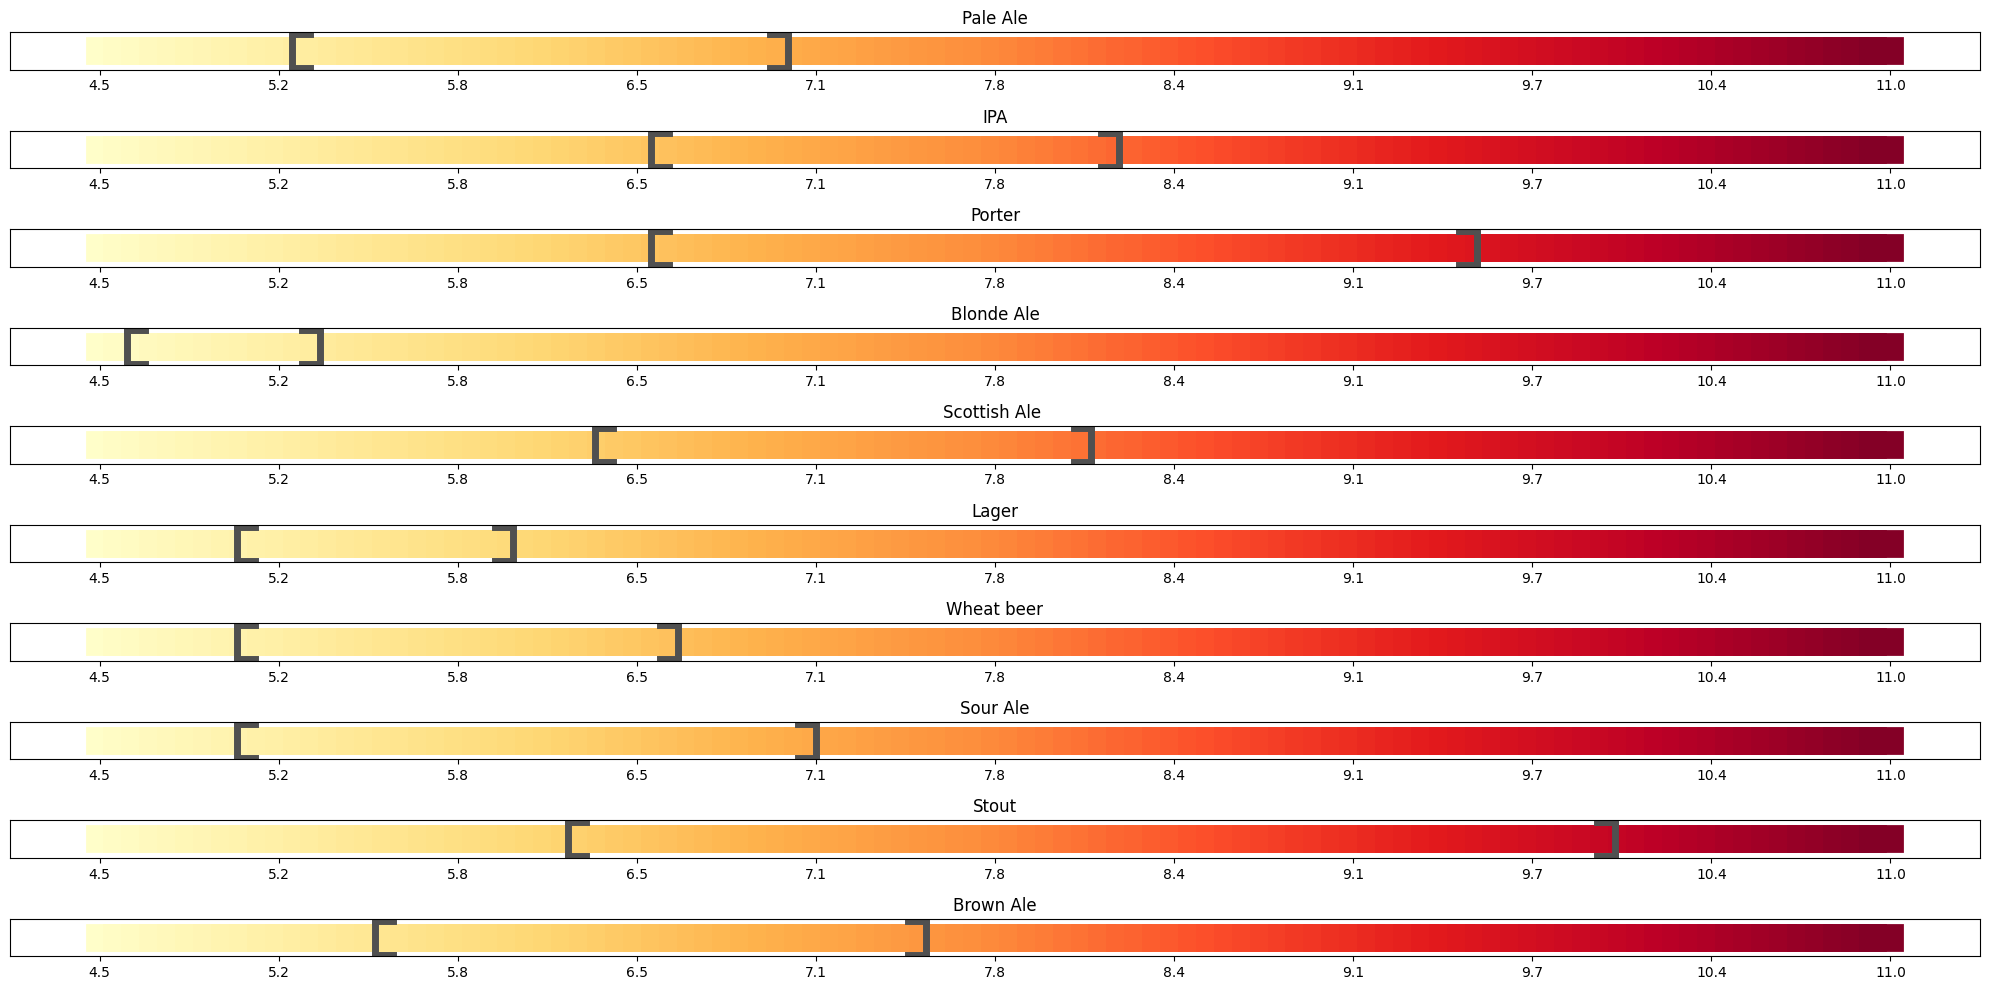

In [161]:
# For each beer type, plot a color line where the min and max limits are the 5th and 95th percentiles of the abv for all beers
# then plot square brackets at the 25th and 75th percentiles of the abv for each beer type

fig, ax = plt.subplots(len(general_beer_types), figsize=(20, 10))

min_abv = quantile_5
max_abv = quantile_95

slope_abv_to_x = 1 / (max_abv - min_abv)
intercept_abv_to_x = -min_abv / (max_abv - min_abv)


for i, beer_type in enumerate(general_beer_types):
    N = 100
    base_colors = sns.color_palette("YlOrRd", N)

    for j in range(N):
        ax[i].plot([j / N, (j + 1) / N], [0, 0], lw=20, c=base_colors[j])

    # Plot brackets at each end
    x_25th = (
        slope_abv_to_x * abv_percentiles_per_beer_type[beer_type][0]
        + intercept_abv_to_x
    )
    x_75th = (
        slope_abv_to_x * abv_percentiles_per_beer_type[beer_type][1]
        + intercept_abv_to_x
    )

    line_color = "#505050"
    ax[i].plot([x_25th, x_25th], [-0.5, 0.5], lw=5, c=line_color)
    ax[i].plot([x_25th, x_25th + 0.01], [-0.5, -0.5], lw=5, c=line_color)
    ax[i].plot([x_25th, x_25th + 0.01], [0.5, 0.5], lw=5, c=line_color)

    ax[i].plot([x_75th, x_75th], [-0.5, 0.5], lw=5, c=line_color)
    ax[i].plot([x_75th - 0.01, x_75th], [-0.5, -0.5], lw=5, c=line_color)
    ax[i].plot([x_75th - 0.01, x_75th], [0.5, 0.5], lw=5, c=line_color)

    ax[i].set_title(beer_type)
    ax[i].set_yticks([])
    ax[i].set_xticks(np.arange(0, 1.1, 0.1))
    ax[i].set_xticklabels(
        np.arange(
            min_abv,
            max_abv + ((max_abv - min_abv) / 10).round(1),
            (max_abv - min_abv) / 10,
        ).round(1)
    )

plt.tight_layout()
plt.show()

We see that even in one style of beer, there is a lot of variability in the alcohol percentage. We will look at the alcohol percentage of the beers in the different climates to see if there is a correlation between the alcohol percentage and the ratings.

# 4) Analysis of the abv

We will now try to find out if there is a correlation between the abv of the beers and the different sort of climates to see if it might explain the differences in the appreciation of the beers.

In [162]:
us_users_ratings_abv = us_users_ratings.copy()

us_users_ratings_abv = us_users_ratings_abv.dropna(subset=["overall", "abv"])

In a first time, let us take a look at abv distribution in our dataset.

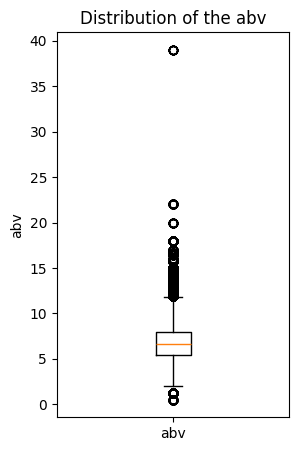

In [163]:
# boxplot of abv of the us
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_users_ratings_abv["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

It appears that there are various outliers with very high value. These risk to bias our means and analysis so we start by removing them. To do so, we compute the 5th and 95th quantile of the abv and remove all the values that are not in this range.

5th percentile: 4.5
95th percentile: 11.0
Shape before filtering: (862743, 36)
Shape after filtering: (783427, 36)
Mean of the abv: 6.87


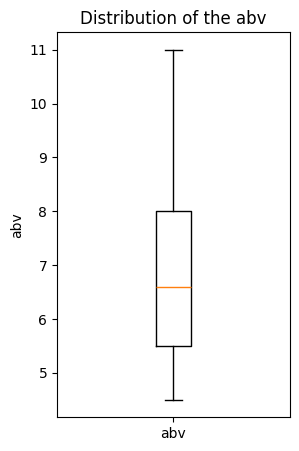

In [164]:
# keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings_abv["abv"].quantile(0.05)
quantile_95 = us_users_ratings_abv["abv"].quantile(0.95)

print("5th percentile:", quantile_5)
print("95th percentile:", quantile_95)

print("Shape before filtering:", us_users_ratings_abv.shape)
us_abv_ratings = us_users_ratings_abv[
    (us_users_ratings_abv["abv"] >= quantile_5)
    & (us_users_ratings_abv["abv"] <= quantile_95)
]
print("Shape after filtering:", us_abv_ratings.shape)

print("Mean of the abv: {:.2f}".format(us_abv_ratings["abv"].mean()))

# Boxplot of the abv of us_abv_ratings
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_abv_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

Now, the data looks more reasonable. We can see that the abv is mostly between 4.5% and 11% with a mean of 6.87%.

## 4.1) Using climate for grouping

We can start by aggregating by climate and see if there is a difference in the abv of the beers.

In [165]:
# sort a dataframe with the name ot the climate
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])

# to store the climate dataframes
climate_dataframes = {}

# create a for loop to create separate dataframes for each climate based on the climate_names
for climate in climate_names["climate"]:
    climate_df = pd.DataFrame(
        us_abv_ratings[us_abv_ratings["climate"] == climate].reset_index(drop=True)
    )
    climate_dataframes[climate] = climate_df.sort_values(
        by="overall", ascending=False
    ).reset_index(drop=True)

We will look at the abv of each climate in three different manners:
- The mean abv of the beers in each climate after weighting them by the `overall` appreciation of the beers
- The mean abv of the beers in each climate after keeping only the 3 best beers in each climate
- The mean abv of the beers in each climate after keeping only the 3 most reviewed beers in each climate

The goal of this is to see if the abv of the beers is correlated with the appreciation of the beers by climate.

In the following cells, we create a new dataset `us_abv_means` that will contain these scores at the end.

In [166]:
# Create the dataset
us_abv_means = pd.DataFrame(
    columns=["climate", "mean_abv_weighted", "mean_abv_best", "mean_abv_most"]
)

# Compute the mean abv for each climate weighted by overall score
for climate in climate_names["climate"]:
    climate_df = us_abv_ratings[us_abv_ratings["climate"] == climate]

    # Compute the mean abv for each climate weighted by overall score

    mean_abv_weighted = (climate_df["abv"] * climate_df["overall"]).sum() / climate_df[
        "overall"
    ].sum()

    us_abv_means.loc[len(us_abv_means)] = [climate, mean_abv_weighted, 0.0, 0.0]


# Find most liked beers for each climate
keeping_best_beers = {}

# create new dataframes containign the best three beers for each climate
for climate, climate_df in climate_dataframes.items():
    us_grouped_beers = climate_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    keeping_best_beers[climate] = climate_df[
        climate_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
for climate in keeping_best_beers:
    # calculate the mean of the abv in the column abv of the dataframe
    mean_abv_best = keeping_best_beers[climate]["abv"].mean()
    us_abv_means.loc[
        us_abv_means["climate"] == climate, "mean_abv_best"
    ] = mean_abv_best


# Find most reviewed beers for each climate
keeping_most_reviewed_beers = {}

for climate, climate_df in climate_dataframes.items():
    # get number of occurences of each style of beer
    num_reviews = climate_df["general_style"].value_counts()

    # keep only the 3 most reviewed beers
    most_reviewed = num_reviews[:3]

    keeping_most_reviewed_beers[climate] = climate_df[
        climate_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
for climate in keeping_most_reviewed_beers:
    # calculate the mean of the abv in the column abv of the dataframe
    mean_abv_most = keeping_most_reviewed_beers[climate]["abv"].mean()
    us_abv_means.loc[
        us_abv_means["climate"] == climate, "mean_abv_most"
    ] = mean_abv_most


display(us_abv_means)

,climate,mean_abv_weighted,mean_abv_best,mean_abv_most
0,Cfa,6.910911,7.356880,6.836905
1,Dfa,6.965748,7.459210,6.903023
2,Cfb,6.758007,7.322380,6.774415
3,Dfb,6.896353,7.336444,6.819313
4,Dfc,6.867785,7.230568,6.766260
5,Dsc,6.795549,7.220047,6.700405
6,Dsb,6.870914,7.244643,6.776383
7,Csa,6.990549,7.300237,6.944616
8,Csb,6.855522,7.170656,6.780525
9,Bsk,6.849988,7.268724,6.807197


Looking at these results numerically make it appear as if there was a slight difference between the climates. However, the difference is not very large, furthermore it is hard to interpret the results without a visual representation.

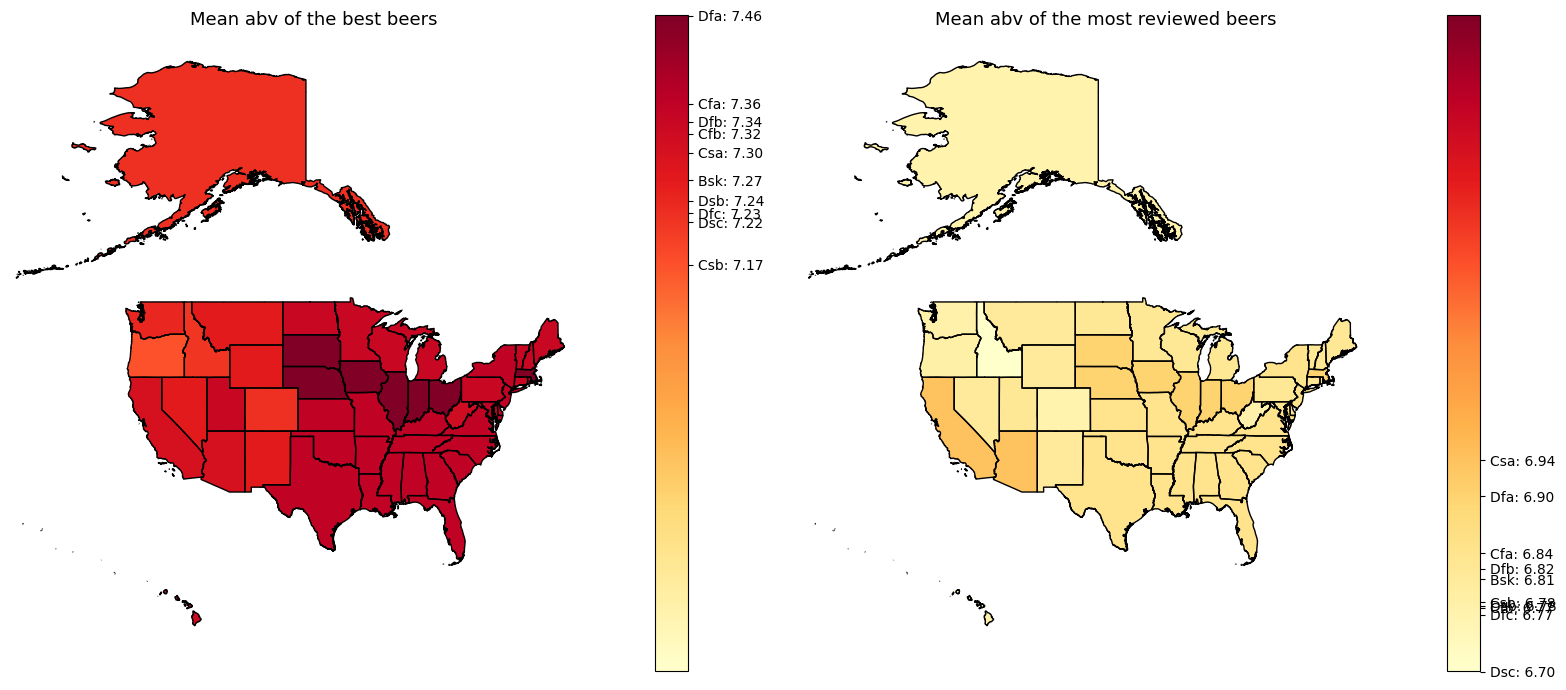

In [167]:
plot_climate_multiple_stats(
    us_abv_means,
    columns=["mean_abv_best", "mean_abv_most"],
    titles=["Mean abv of the best beers", "Mean abv of the most reviewed beers"],
    column_ticks=["climate", "climate"],
    cmap_name="YlOrRd",
)

We also check the statistical significance of the difference between the climates by performing a one-way ANOVA test. The null hypothesis is that the means of the abv of the beers in each climate are equal.

In [168]:
# One-way ANOVA test for the mean abv of each climate
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate == zone]["abv"]
        for zone in us_abv_ratings.climate.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate
res = stats.f_oneway(
    *[keeping_best_beers[zone]["abv"] for zone in keeping_best_beers.keys()], axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate:", res[1])

# One-way ANOVA test for the mean abv of most reviewed beers of each climate
res = stats.f_oneway(
    *[
        keeping_most_reviewed_beers[zone]["abv"]
        for zone in keeping_most_reviewed_beers.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate: 5.168135814480176e-101
One-way ANOVA test for the mean abv of best beers of each climate: 3.2478243684297135e-121
One-way ANOVA test for the mean abv of most reviewed beers of each climate: 1.789496735888541e-114


They are indeed below the threshold of 0.05, which means that we can reject the null hypothesis and say that the means are different.

## 4.2) Analysis of the subcategories of the climates

As before, we will now look at the abv of the beers in each subcategory of the climates. We will start with the schemes that we used before:

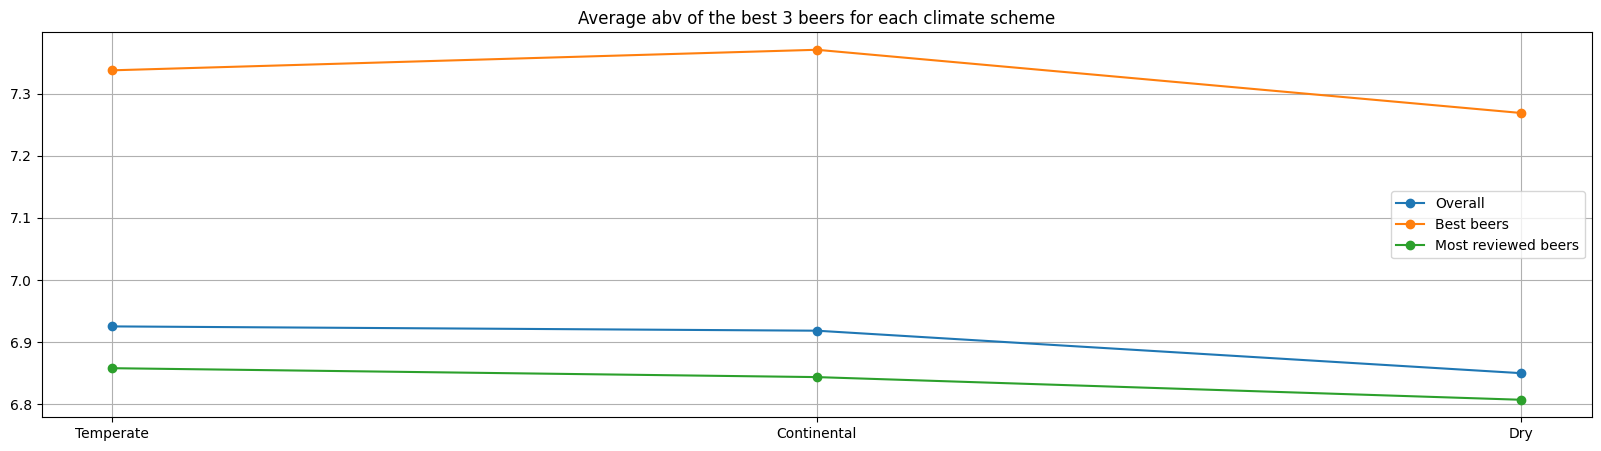

In [169]:
# Now test the climate scheme
mean_abv_weighted = {}
best_beers_scheme_dfs = {}
best_beers_scheme_abv = {}
most_reviewed_scheme_dfs = {}
most_reviewed_scheme_abv = {}

for climate_s in us_users_ratings_abv["climate_scheme"].unique():
    climate_scheme_df = us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_s]

    mean_abv_weighted[climate_s] = (
        climate_scheme_df["abv"] * climate_scheme_df["overall"]
    ).sum() / climate_scheme_df["overall"].sum()

    us_grouped_beers = climate_scheme_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_scheme_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_scheme_dfs[climate_s] = climate_scheme_df[
        climate_scheme_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
    best_beers_scheme_abv[climate_s] = best_beers_scheme_dfs[climate_s]["abv"].mean()

    most_reviewed_scheme_dfs[climate_s] = climate_scheme_df[
        climate_scheme_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
    most_reviewed_scheme_abv[climate_s] = most_reviewed_scheme_dfs[climate_s][
        "abv"
    ].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_weighted[climate_s]
        for climate_s in us_users_ratings_abv["climate_scheme"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_scheme_abv[climate_s]
        for climate_s in us_users_ratings_abv["climate_scheme"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_scheme_abv[climate_s]
        for climate_s in us_users_ratings_abv["climate_scheme"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings_abv["climate_scheme"].unique())),
    us_users_ratings_abv["climate_scheme"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate scheme")
ax.grid()
ax.legend()
plt.show()

It appears that they are indeed some variations between the subcategories of the climates. Let's plot them on a map to see if we can see some patterns.

,climate,climate_scheme,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,Temperate,7.337447,6.858030,6.925281
1,Dfa,Continental,7.370499,6.843697,6.918382
2,Cfb,Temperate,7.337447,6.858030,6.925281
3,Dfb,Continental,7.370499,6.843697,6.918382
4,Dfc,Continental,7.370499,6.843697,6.918382
5,Dsc,Continental,7.370499,6.843697,6.918382
6,Dsb,Continental,7.370499,6.843697,6.918382
7,Csa,Temperate,7.337447,6.858030,6.925281
8,Csb,Temperate,7.337447,6.858030,6.925281
9,Bsk,Dry,7.268724,6.807197,6.849988


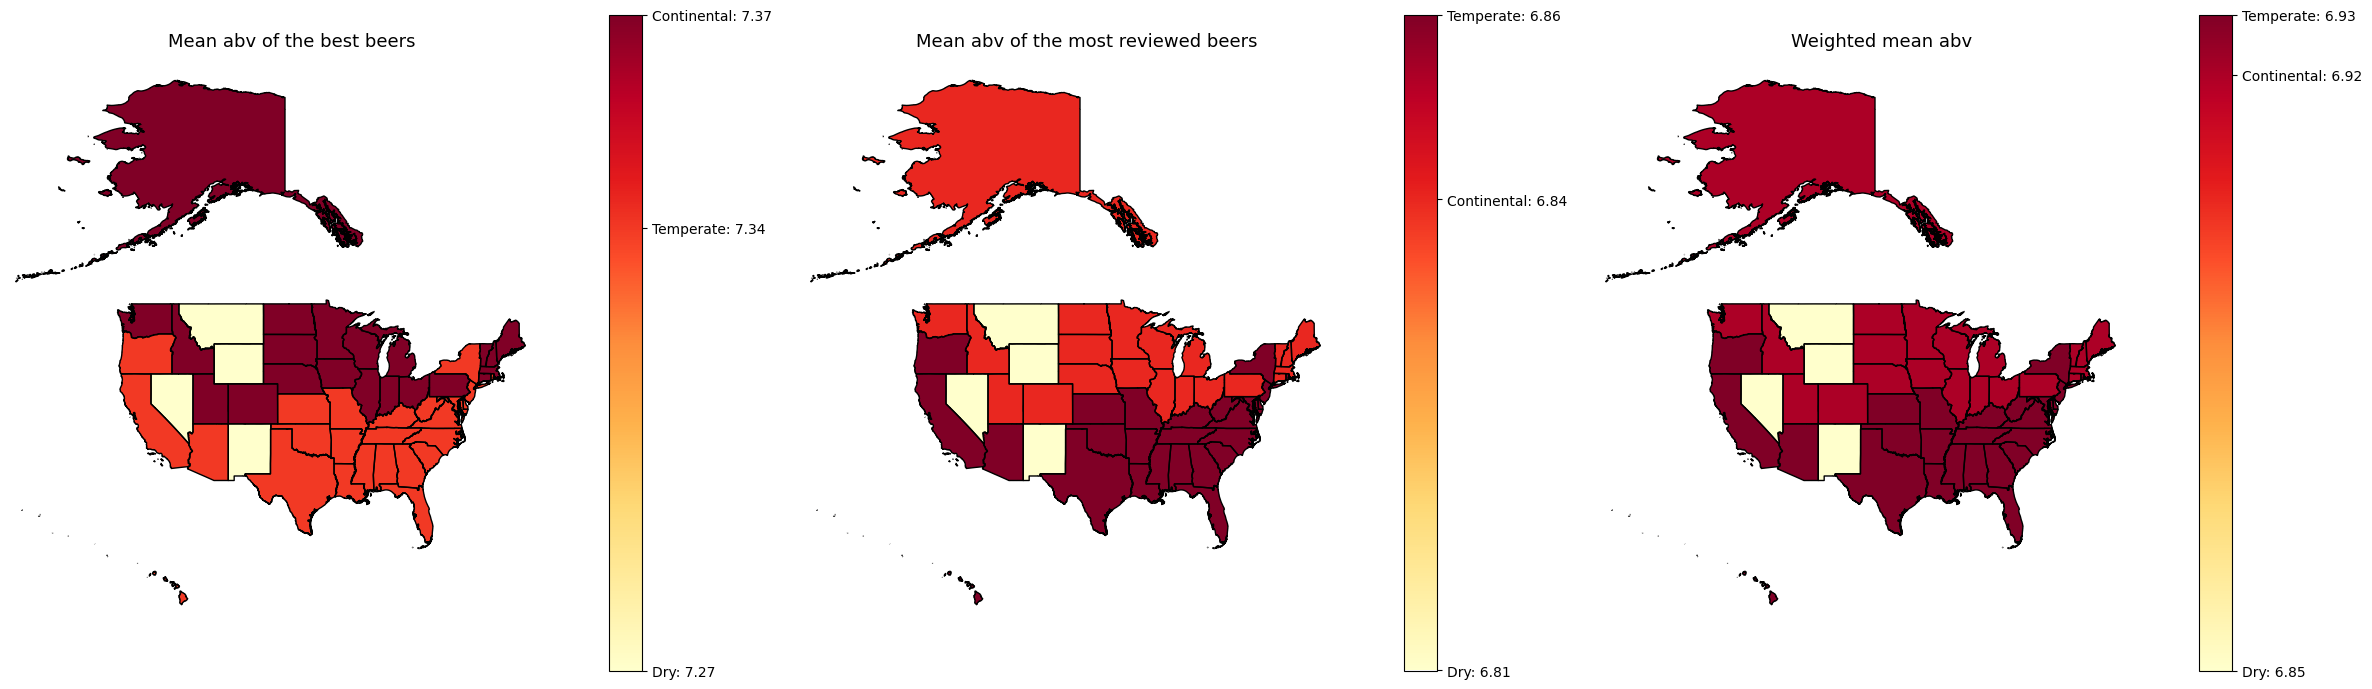

In [170]:
# load the df with the climate classified
climate_classified = pd.read_csv("data/climate_classified.csv")

# create a df with all the climate in a column,
# in the second the corresponding climate scheme a
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])
climate_names["climate_scheme"] = climate_names["climate"].map(
    climate_classified.set_index("climate")["scheme"]
)
# in the third the average abv of the best 3 beers for each climate scheme
climate_names["abv_mean"] = climate_names["climate_scheme"].map(best_beers_scheme_abv)

# in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names["abv_mean_most_reviewd"] = climate_names["climate_scheme"].map(
    most_reviewed_scheme_abv
)

# in the fifth the average abv of all the beers for each climate scheme
climate_names["abv_mean_overall"] = climate_names["climate_scheme"].map(
    mean_abv_weighted
)

display(climate_names)

plot_climate_multiple_stats(
    climate_names,
    columns=["abv_mean", "abv_mean_most_reviewd", "abv_mean_overall"],
    titles=[
        "Mean abv of the best beers",
        "Mean abv of the most reviewed beers",
        "Weighted mean abv",
    ],
    column_ticks=["climate_scheme", "climate_scheme", "climate_scheme"],
    cmap_name="YlOrRd",
    separate_colorbars=True,
)

In [171]:
# One-way ANOVA test for the mean abv of each climate scheme
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_scheme == zone]["abv"]
        for zone in us_abv_ratings.climate_scheme.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate scheme:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate scheme
res = stats.f_oneway(
    *[best_beers_scheme_dfs[zone]["abv"] for zone in best_beers_scheme_dfs.keys()],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1]
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate scheme
res = stats.f_oneway(
    *[
        most_reviewed_scheme_dfs[zone]["abv"]
        for zone in most_reviewed_scheme_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1]
)

One-way ANOVA test for the mean abv of each climate scheme: 1.4982658694334239e-06
One-way ANOVA test for the mean abv of best beers of each climate scheme: 2.1477906266220373e-11
One-way ANOVA test for the mean abv of best beers of each climate scheme: 0.00031254912410991274


The previous one-way ANOVA test show that these variations are statistically significant.

We can now look at the climate precipitation and abv.

Overall average of best beers for climate without dry season: 3.981228746091151
Overall average of most reviewed beers for climate without dry season: 3.8670259238566245
Overall average of best beers for climate with dry season: 3.9844210078923337
Overall average of most reviewed beers for climate with dry season: 3.87191618588856


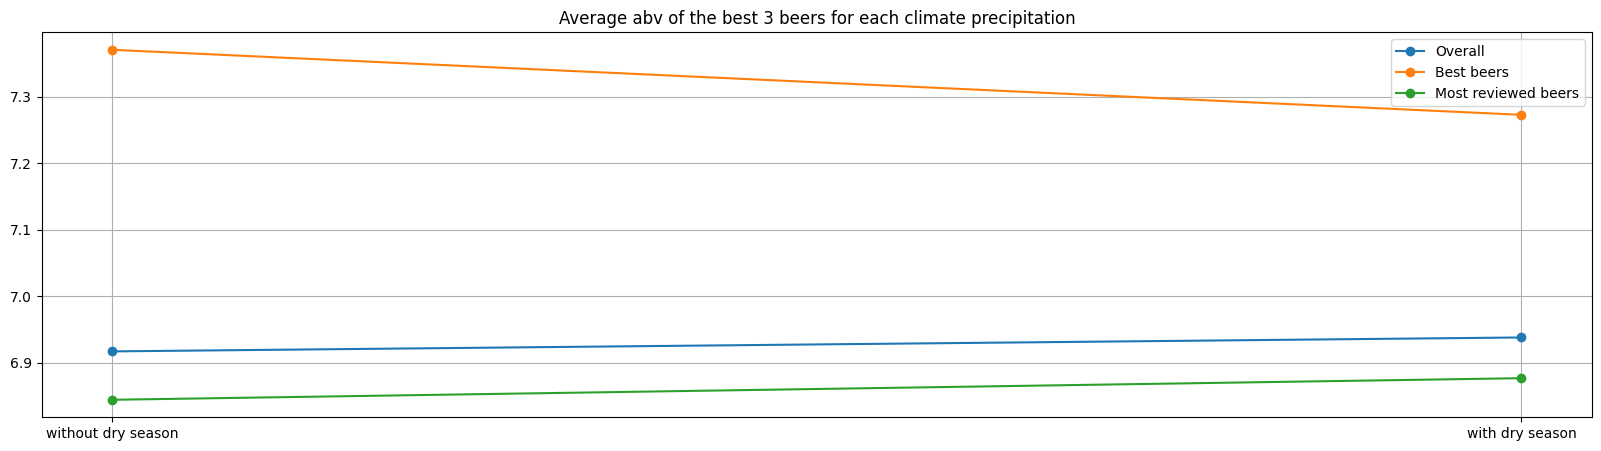

In [172]:
# Now test the climate precipitation, as there are multiple values, let's check their abv differences globally first
mean_abv_weighted = {}
best_beers_precipitation_dfs = {}
best_beers_precipitation_abv = {}
most_reviewed_precipitation_dfs = {}
most_reviewed_precipitation_abv = {}

for climate_p in us_users_ratings_abv["climate_precipitation"].unique():
    climate_precipitation_df = us_abv_ratings[
        us_abv_ratings["climate_precipitation"] == climate_p
    ]

    mean_abv_weighted[climate_p] = (
        climate_precipitation_df["abv"] * climate_precipitation_df["overall"]
    ).sum() / climate_precipitation_df["overall"].sum()

    us_grouped_beers = climate_precipitation_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_precipitation_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_precipitation_dfs[climate_p] = climate_precipitation_df[
        climate_precipitation_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)

    print(
        "Overall average of best beers for climate {}: {}".format(
            climate_p, best_beers_precipitation_dfs[climate_p]["overall"].mean()
        )
    )

    best_beers_precipitation_abv[climate_p] = best_beers_precipitation_dfs[climate_p][
        "abv"
    ].mean()

    most_reviewed_precipitation_dfs[climate_p] = climate_precipitation_df[
        climate_precipitation_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)

    print(
        "Overall average of most reviewed beers for climate {}: {}".format(
            climate_p, most_reviewed_precipitation_dfs[climate_p]["overall"].mean()
        )
    )

    most_reviewed_precipitation_abv[climate_p] = most_reviewed_precipitation_dfs[
        climate_p
    ]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_weighted[climate_p]
        for climate_p in us_users_ratings_abv["climate_precipitation"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_precipitation_abv[climate_p]
        for climate_p in us_users_ratings_abv["climate_precipitation"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_precipitation_abv[climate_p]
        for climate_p in us_users_ratings_abv["climate_precipitation"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings_abv["climate_precipitation"].unique())),
    us_users_ratings_abv["climate_precipitation"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate precipitation")
ax.grid()
ax.legend()
plt.show()

,climate,climate_precipitation,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,without dry season,7.370849,6.844568,6.917327
1,Dfa,without dry season,7.370849,6.844568,6.917327
2,Cfb,without dry season,7.370849,6.844568,6.917327
3,Dfb,without dry season,7.370849,6.844568,6.917327
4,Dfc,without dry season,7.370849,6.844568,6.917327
5,Dsc,with dry season,7.273038,6.877023,6.938266
6,Dsb,with dry season,7.273038,6.877023,6.938266
7,Csa,with dry season,7.273038,6.877023,6.938266
8,Csb,with dry season,7.273038,6.877023,6.938266
9,Bsk,with dry season,7.273038,6.877023,6.938266


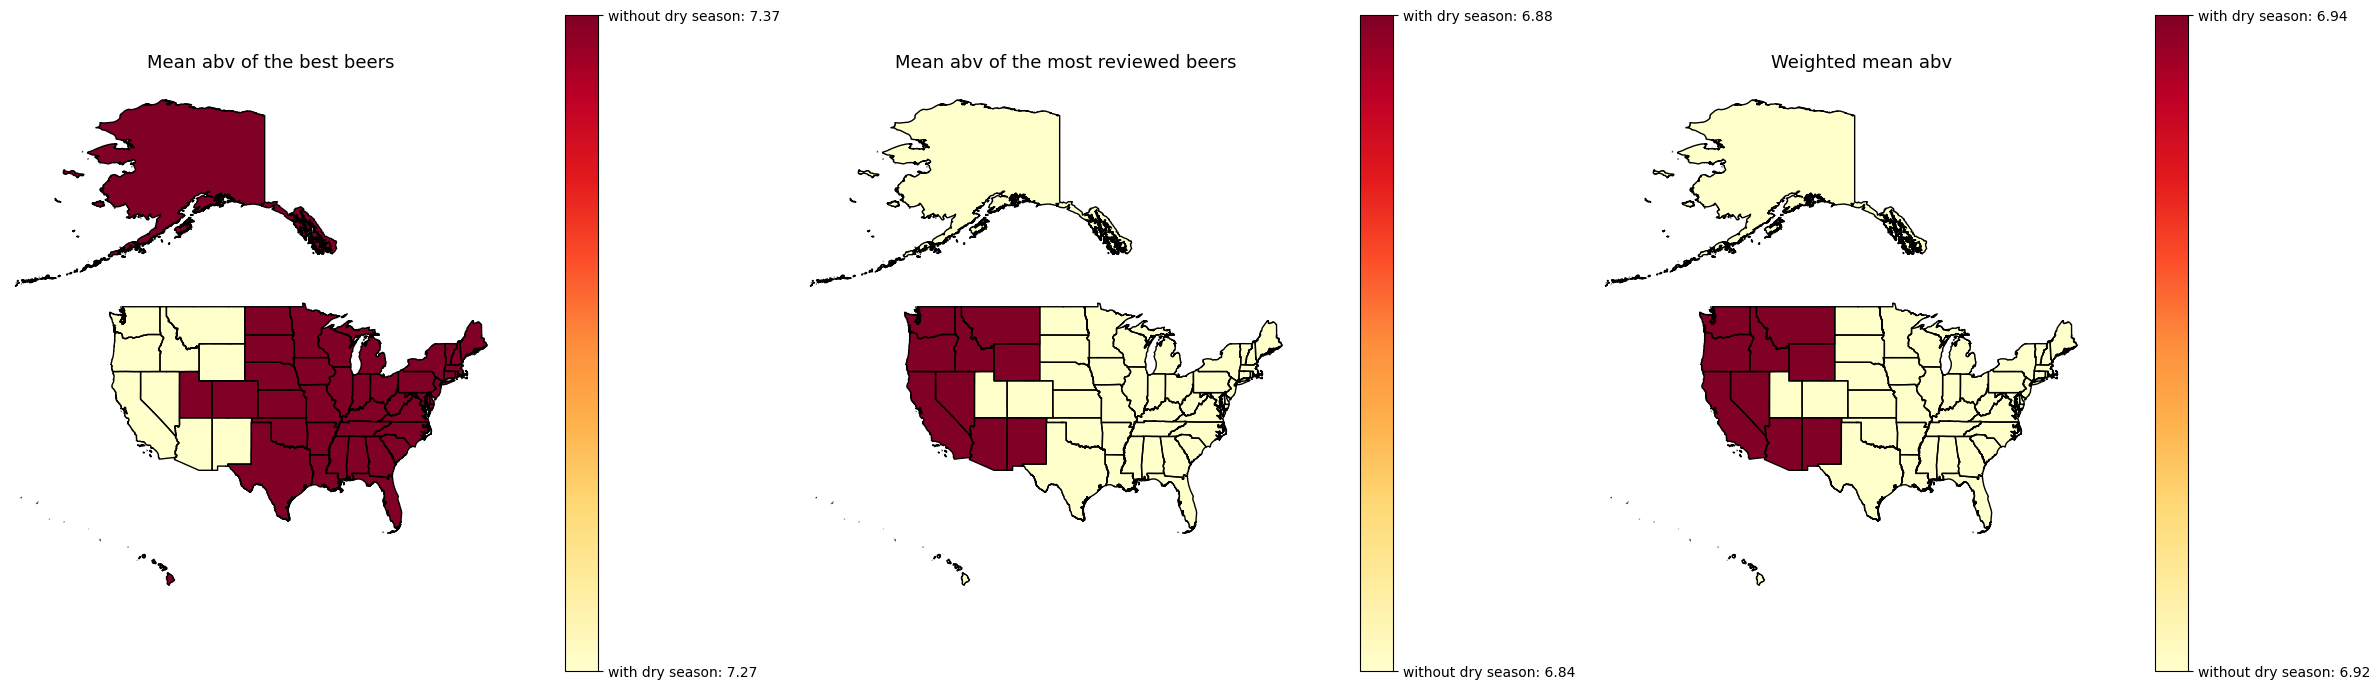

In [173]:
# load the df with the climate classified
climate_classified = pd.read_csv("data/climate_classified.csv")

# create a df with all the cliate in a column,
# in the second the corresponding climate precipitation a
climate_names_precipitation = pd.DataFrame(
    us_abv_ratings["climate"].unique(), columns=["climate"]
)
climate_names_precipitation["climate_precipitation"] = climate_names_precipitation[
    "climate"
].map(climate_classified.set_index("climate")["seasonal_precipitation"])
# in the third the average abv of the best 3 beers for each climate scheme
climate_names_precipitation["abv_mean"] = climate_names_precipitation[
    "climate_precipitation"
].map(best_beers_precipitation_abv)

# in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names_precipitation["abv_mean_most_reviewd"] = climate_names_precipitation[
    "climate_precipitation"
].map(most_reviewed_precipitation_abv)

# in the fifth the average abv of all the beers for each climate scheme
climate_names_precipitation["abv_mean_overall"] = climate_names_precipitation[
    "climate_precipitation"
].map(mean_abv_weighted)

display(climate_names_precipitation)

plot_climate_multiple_stats(
    climate_names_precipitation,
    columns=["abv_mean", "abv_mean_most_reviewd", "abv_mean_overall"],
    titles=[
        "Mean abv of the best beers",
        "Mean abv of the most reviewed beers",
        "Weighted mean abv",
    ],
    column_ticks=[
        "climate_precipitation",
        "climate_precipitation",
        "climate_precipitation",
    ],
    cmap_name="YlOrRd",
    separate_colorbars=True,
)

In [174]:
# One-way ANOVA test for the mean abv of each climate precipitation
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_precipitation == zone]["abv"]
        for zone in us_abv_ratings.climate_precipitation.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate precipitation:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate precipitation
res = stats.f_oneway(
    *[
        best_beers_precipitation_dfs[zone]["abv"]
        for zone in best_beers_precipitation_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate precipitation:",
    res[1],
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation
res = stats.f_oneway(
    *[
        most_reviewed_precipitation_dfs[zone]["abv"]
        for zone in most_reviewed_precipitation_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate precipitation: 5.08100276710351e-08
One-way ANOVA test for the mean abv of best beers of each climate precipitation: 3.001034176773221e-46
One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation: 2.716777093164039e-09


Similarly, we can look at the climate temperature and abv.

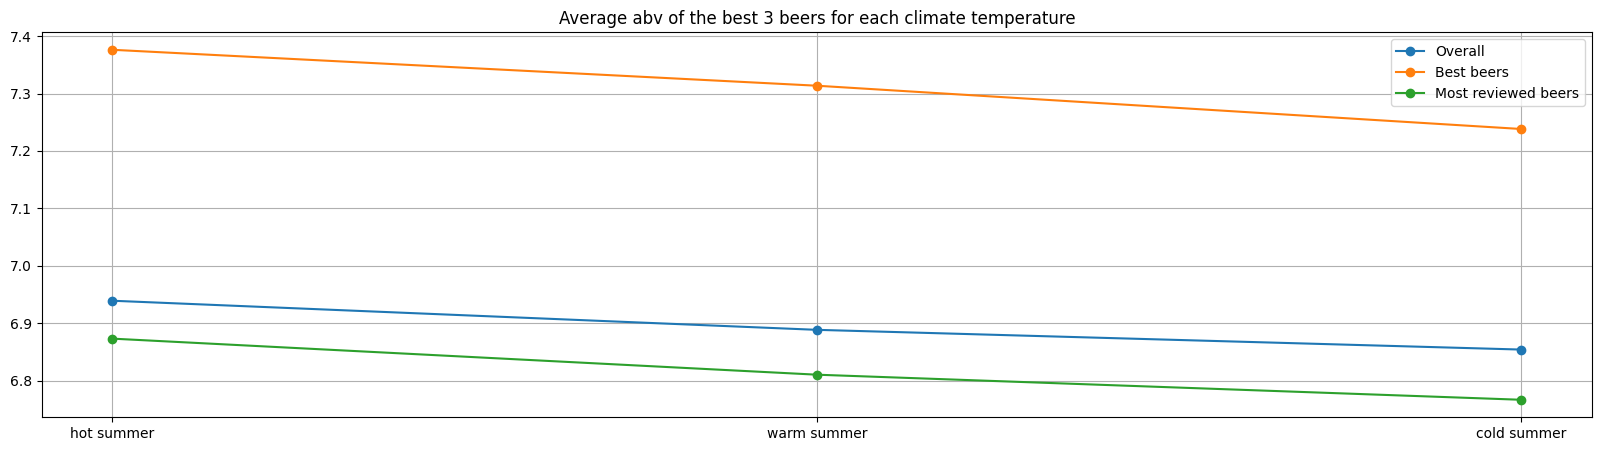

In [175]:
# Now test the climate temperature, as there are multiple values, let's check their abv differences globally first
mean_abv_weighted = {}
best_beers_temperature_dfs = {}
best_beers_temperature_abv = {}
most_reviewed_temperature_dfs = {}
most_reviewed_temperature_abv = {}

for climate_t in us_users_ratings_abv["climate_temperature"].unique():
    climate_temperature_df = us_abv_ratings[
        us_abv_ratings["climate_temperature"] == climate_t
    ]
    mean_abv_weighted[climate_t] = (
        climate_temperature_df["abv"] * climate_temperature_df["overall"]
    ).sum() / climate_temperature_df["overall"].sum()

    us_grouped_beers = climate_temperature_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_temperature_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_temperature_dfs[climate_t] = climate_temperature_df[
        climate_temperature_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
    best_beers_temperature_abv[climate_t] = best_beers_temperature_dfs[climate_t][
        "abv"
    ].mean()

    most_reviewed_temperature_dfs[climate_t] = climate_temperature_df[
        climate_temperature_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
    most_reviewed_temperature_abv[climate_t] = most_reviewed_temperature_dfs[climate_t][
        "abv"
    ].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_weighted[climate_t]
        for climate_t in us_users_ratings_abv["climate_temperature"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_temperature_abv[climate_t]
        for climate_t in us_users_ratings_abv["climate_temperature"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_temperature_abv[climate_t]
        for climate_t in us_users_ratings_abv["climate_temperature"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings_abv["climate_temperature"].unique())),
    us_users_ratings_abv["climate_temperature"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate temperature")
ax.grid()
ax.legend()
plt.show()

,climate,climate_heating,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,hot summer,7.376178,6.873136,6.939144
1,Dfa,hot summer,7.376178,6.873136,6.939144
2,Cfb,warm summer,7.313592,6.810338,6.888453
3,Dfb,warm summer,7.313592,6.810338,6.888453
4,Dfc,cold summer,7.238193,6.766647,6.854075
5,Dsc,cold summer,7.238193,6.766647,6.854075
6,Dsb,warm summer,7.313592,6.810338,6.888453
7,Csa,hot summer,7.376178,6.873136,6.939144
8,Csb,warm summer,7.313592,6.810338,6.888453
9,Bsk,cold summer,7.238193,6.766647,6.854075


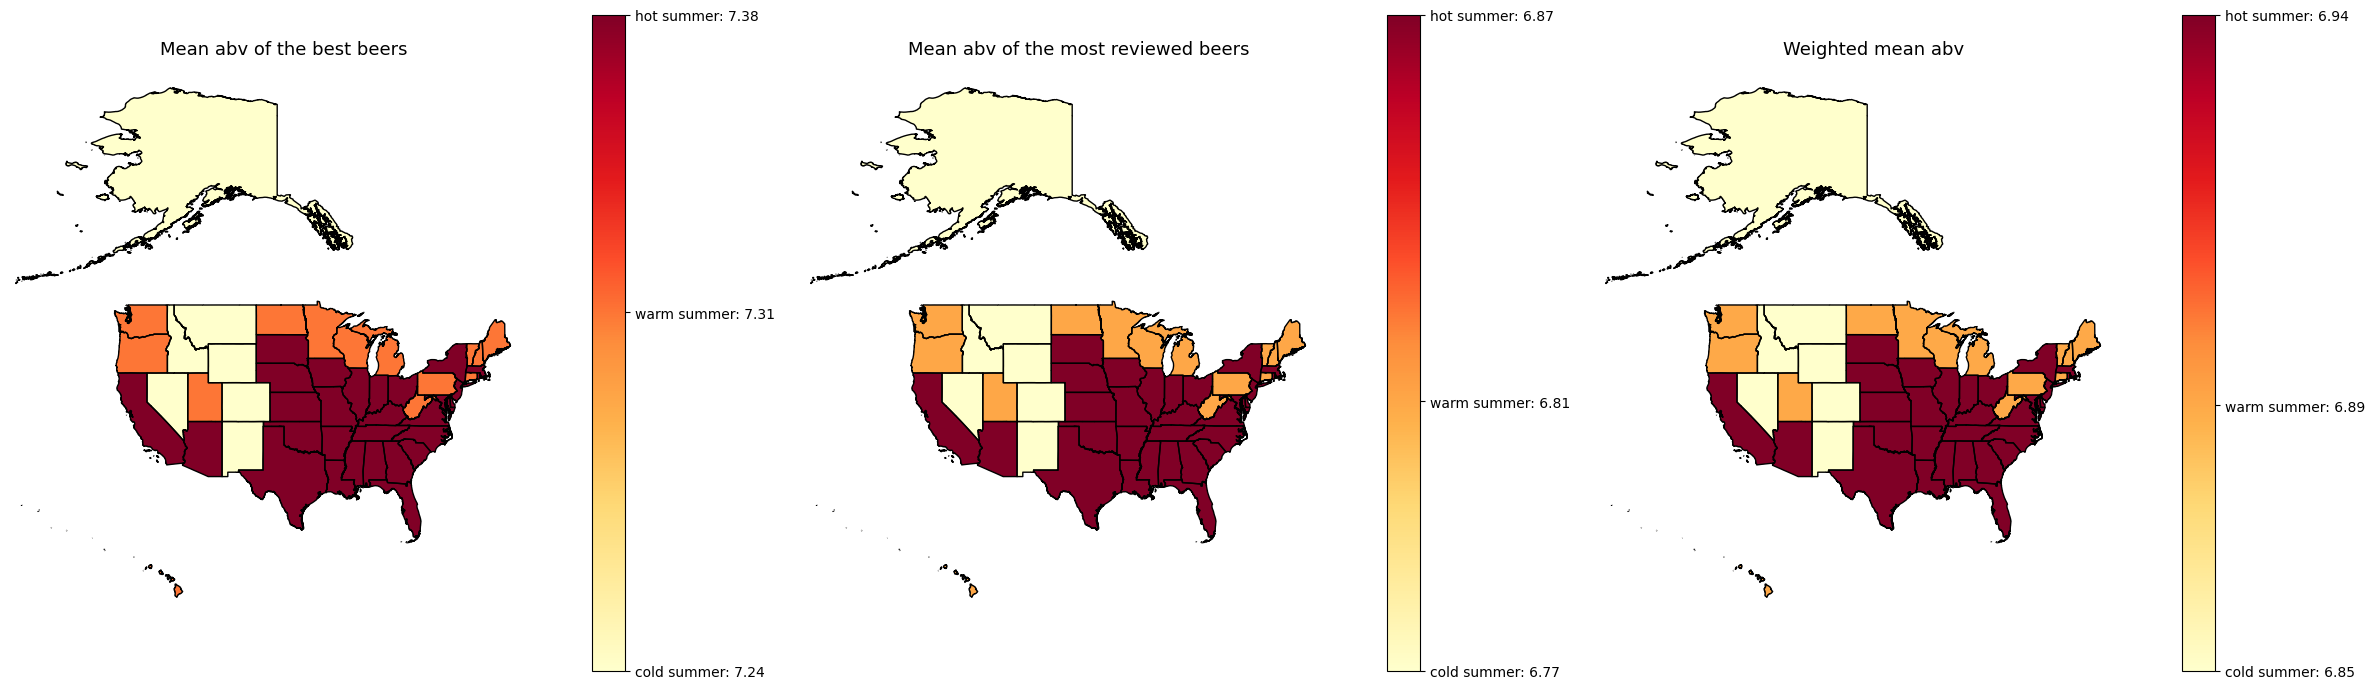

In [176]:
# load the df with the climate classified
climate_classified = pd.read_csv("data/climate_classified.csv")

# create a df with all the cliate in a column,
# in the second the corresponding climate precipitation a
climate_names_heating = pd.DataFrame(
    us_abv_ratings["climate"].unique(), columns=["climate"]
)
climate_names_heating["climate_heating"] = climate_names_heating["climate"].map(
    climate_classified.set_index("climate")["heat_level"]
)
# in the third the average abv of the best 3 beers for each climate scheme
climate_names_heating["abv_mean"] = climate_names_heating["climate_heating"].map(
    best_beers_temperature_abv
)
climate_names_heating.head(10)

# in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names_heating["abv_mean_most_reviewd"] = climate_names_heating[
    "climate_heating"
].map(most_reviewed_temperature_abv)

# in the fifth the average abv of all the beers for each climate scheme
climate_names_heating["abv_mean_overall"] = climate_names_heating[
    "climate_heating"
].map(mean_abv_weighted)

display(climate_names_heating)

plot_climate_multiple_stats(
    climate_names_heating,
    columns=["abv_mean", "abv_mean_most_reviewd", "abv_mean_overall"],
    titles=[
        "Mean abv of the best beers",
        "Mean abv of the most reviewed beers",
        "Weighted mean abv",
    ],
    column_ticks=["climate_heating", "climate_heating", "climate_heating"],
    cmap_name="YlOrRd",
    separate_colorbars=True,
)

In [177]:
# One-way ANOVA test for the mean abv of each climate temperature
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_temperature == zone]["abv"]
        for zone in us_abv_ratings.climate_temperature.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate temperature:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate temperature
res = stats.f_oneway(
    *[
        best_beers_temperature_dfs[zone]["abv"]
        for zone in best_beers_temperature_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate temperature:",
    res[1],
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature
res = stats.f_oneway(
    *[
        most_reviewed_temperature_dfs[zone]["abv"]
        for zone in most_reviewed_temperature_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate temperature: 8.852111294633652e-47
One-way ANOVA test for the mean abv of best beers of each climate temperature: 5.085188781335966e-44
One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature: 4.134520396406789e-56
